In [1]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
from openpyxl import load_workbook
from openpyxl.utils.cell import range_boundaries

## Modelo de especificação e utilitários
Aqui ficam o `dataclass` com as opções do gráfico e funções auxiliares de leitura/conversão.

In [2]:
@dataclass(frozen=True)
class ExcelBarChartSpec:
    file_path: Union[str, Path]
    sheet_name: str
    values_range: str
    xlabels_range: str
    ylabel_cell: Optional[str] = None
    title: Optional[str] = None
    highlight_last: bool = True
    output_path: Optional[Union[str, Path]] = None
    show_delta_pct: bool = False
    show_delta_bracket: bool = False
    # Casas decimais nos valores no topo das barras
    value_decimals: int = 0
    # Escala da largura das barras (1.0 = normal)
    bar_width_scale: float = 1.0
    # Cor fixa para todas as barras (quando definido, ignora highlight_last)
    bar_color: Optional[str] = None
    # Pares (prev, curr) para comparar. Aceita índices negativos (estilo Python).
    # Ex.: ((-2, -1), (-5, -2)) = (penúltimo vs último) e (penúltimo-3 vs penúltimo)
    delta_pairs: Tuple[Tuple[int, int], ...] = ()
    # Para gráficos com poucas barras (ex.: 2), força uma malha maior de categorias
    # para as barras ficarem com largura visual similar ao gráfico principal.
    fixed_slot_count: Optional[int] = None


def _read_range_row(ws, cell_range: str) -> List[object]:
    min_col, min_row, max_col, max_row = range_boundaries(cell_range)
    out: List[object] = []
    for r in range(min_row, max_row + 1):
        for c in range(min_col, max_col + 1):
            out.append(ws.cell(row=r, column=c).value)
    return out


def _to_float_list(values: List[object]) -> List[float]:
    out: List[float] = []
    for v in values:
        if v is None or (isinstance(v, str) and v.strip() == ""):
            out.append(0.0)
            continue
        try:
            out.append(float(v))
        except (TypeError, ValueError) as exc:
            raise ValueError(f"Valor não numérico no range: {v!r}") from exc
    return out


def _pchip_interpolate(x: np.ndarray, y: np.ndarray, x_new: np.ndarray) -> np.ndarray:
    """Monotone cubic interpolation (PCHIP) in NumPy only.

    Produz uma curva suave sem 'overshoot' entre pontos (bom para séries financeiras).
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    x_new = np.asarray(x_new, dtype=float)
    n = x.size
    if n < 2:
        return np.full_like(x_new, y[0] if n else np.nan, dtype=float)
    if np.any(np.diff(x) <= 0):
        raise ValueError("x deve ser estritamente crescente")

    h = np.diff(x)
#label_below
    delta = np.diff(y) / h
    d = np.zeros(n, dtype=float)

    if n == 2:
        d[0] = delta[0]
        d[1] = delta[0]
    else:
        # Tangentes internas
        for i in range(1, n - 1):
            if delta[i - 1] == 0.0 or delta[i] == 0.0 or np.sign(delta[i - 1]) != np.sign(delta[i]):
                d[i] = 0.0
            else:
                w1 = 2 * h[i] + h[i - 1]
                w2 = h[i] + 2 * h[i - 1]
                d[i] = (w1 + w2) / (w1 / delta[i - 1] + w2 / delta[i])

        # Endpoints (Fritsch–Carlson)
        d0 = ((2 * h[0] + h[1]) * delta[0] - h[0] * delta[1]) / (h[0] + h[1])
        if np.sign(d0) != np.sign(delta[0]):
            d0 = 0.0
        elif (np.sign(delta[0]) != np.sign(delta[1])) and (abs(d0) > abs(3 * delta[0])):
            d0 = 3 * delta[0]
        d[0] = d0

        dn = ((2 * h[-1] + h[-2]) * delta[-1] - h[-1] * delta[-2]) / (h[-1] + h[-2])
        if np.sign(dn) != np.sign(delta[-1]):
            dn = 0.0
        elif (np.sign(delta[-1]) != np.sign(delta[-2])) and (abs(dn) > abs(3 * delta[-1])):
            dn = 3 * delta[-1]
        d[-1] = dn

    # Avaliação por trecho (vectorizado)
    idx = np.searchsorted(x, x_new, side="right") - 1
    idx = np.clip(idx, 0, n - 2)
    xk = x[idx]
    xk1 = x[idx + 1]
    hk = xk1 - xk
    t = (x_new - xk) / hk

    yk = y[idx]
    yk1 = y[idx + 1]
    dk = d[idx]
    dk1 = d[idx + 1]

    t2 = t * t
    t3 = t2 * t
    h00 = 2 * t3 - 3 * t2 + 1
    h10 = t3 - 2 * t2 + t
    h01 = -2 * t3 + 3 * t2
    h11 = t3 - t2

    return h00 * yk + h10 * hk * dk + h01 * yk1 + h11 * hk * dk1

## Função: gráfico de barras
Lê valores e rótulos do Excel e gera um gráfico de barras, com destaque opcional na última barra.

In [3]:
def plot_bar_from_excel(spec: ExcelBarChartSpec) -> Tuple[plt.Figure, plt.Axes]:
    file_path = Path(spec.file_path)
    if not file_path.exists():
        raise FileNotFoundError(f"Arquivo não encontrado: {file_path}")

    wb = load_workbook(filename=file_path, data_only=True)
    if spec.sheet_name not in wb.sheetnames:
        raise ValueError(
            f"Aba não encontrada: {spec.sheet_name!r}. Disponíveis: {wb.sheetnames}"
        )

    ws = wb[spec.sheet_name]

    values = _to_float_list(_read_range_row(ws, spec.values_range))
    xlabels = ["" if v is None else str(v) for v in _read_range_row(ws, spec.xlabels_range)]

    if len(values) != len(xlabels):
        raise ValueError(f"Tamanhos diferentes: valores={len(values)} xlabels={len(xlabels)}")

    fig, ax = plt.subplots(figsize=(10, 4.8))
    # Fundo transparente
    fig.patch.set_alpha(0)
    ax.set_facecolor("none")

    n = len(values)

    bar_color = getattr(spec, "bar_color", None)
    if bar_color:
        colors = [str(bar_color)] * n
    else:
        colors = ["#8d98a6"] * n
        if spec.highlight_last and colors:
            colors[-1] = "#123a7a"

    # Mantém a "espessura" visual do gráfico principal sem criar áreas vazias no PNG.
    # Para o 9M (2 barras), também reduz o espaçamento e aumenta fontes (tudo fica legível).
    base_width = 0.8 * float(getattr(spec, "bar_width_scale", 1.0) or 1.0)
    slot_count = int(spec.fixed_slot_count) if spec.fixed_slot_count else n
    slot_count = max(slot_count, n)
    ratio = n / slot_count if slot_count else 1.0
    width = base_width if slot_count == n else base_width * float(np.sqrt(ratio))

    is_9m_two_bars = bool(spec.fixed_slot_count) and n == 2 and slot_count > n

    # Fontes
    font_base = 9
    if is_9m_two_bars:
        font_base = 12
    font_value = font_base
    font_xtick = font_base
    font_delta = font_base

    step = 1.0
    x_pad = 0.5
    if is_9m_two_bars:
        step = 0.48
        x_pad = 0.35
    x_pos = np.arange(n, dtype=float) * step

    bars = ax.bar(x_pos, values, width=width, color=colors, edgecolor="none")
    ax.set_xlim(x_pos.min() - x_pad, x_pos.max() + x_pad)

    # Rótulo do valor em cada barra (último em negrito)
    decimals = int(getattr(spec, "value_decimals", 0) or 0)
    decimals = max(0, decimals)
    last_idx = n - 1
    for i, (rect, val) in enumerate(zip(bars, values)):
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            rect.get_height(),
            f"{float(val):,.{decimals}f}".replace(",", "."),
            ha="center",
            va="bottom",
            fontsize=font_value,
            fontweight="bold" if i == last_idx else "normal",
            color="#2f2f2f",
        )

    # Variação % entre períodos (pares customizáveis)
    delta_label_top: Optional[float] = None
    if spec.show_delta_pct and n >= 2:
        vals = np.asarray(values, dtype=float)
        abs_max = float(np.nanmax(np.abs(vals))) if np.isfinite(np.nanmax(np.abs(vals))) else 0.0
        offset_y = max(abs_max * 0.06, 0.5)
        bracket_h = max(abs_max * 0.03, 0.5)

        pairs = list(spec.delta_pairs) if spec.delta_pairs else [(i - 1, i) for i in range(1, n)]

        def _norm_index(idx: int) -> int:
            return idx + n if idx < 0 else idx

        norm_pairs: List[Tuple[int, int]] = []
        for prev_i, curr_i in pairs:
            pi = _norm_index(int(prev_i))
            ci = _norm_index(int(curr_i))
            if pi < 0 or pi >= n or ci < 0 or ci >= n or pi == ci:
                continue
            norm_pairs.append((pi, ci))

        norm_pairs_sorted = sorted(norm_pairs, key=lambda p: (abs(p[1] - p[0]), p[0], p[1]))

        for level, (pi, ci) in enumerate(norm_pairs_sorted):
            prev = vals[pi]
            curr = vals[ci]
            if not np.isfinite(prev) or not np.isfinite(curr) or prev == 0:
                continue
            pct = (curr / prev - 1.0) * 100.0
            label = f"{pct:+.1f}%".replace(".", ",")

            x1 = bars[pi].get_x() + bars[pi].get_width() / 2
            x2 = bars[ci].get_x() + bars[ci].get_width() / 2

            top = max(prev, curr)
            base = top + offset_y if top >= 0 else top - offset_y
            y_anchor = base + level * (bracket_h + offset_y * 0.9)

            if spec.show_delta_bracket:
                ax.plot(
                    [x1, x1, x2, x2],
                    [y_anchor, y_anchor + bracket_h, y_anchor + bracket_h, y_anchor],
                    color="#2f2f2f",
                    linewidth=1.2,
                    solid_capstyle="round",
                    zorder=4,
                )
                text_y = y_anchor + bracket_h + offset_y * 0.25
            else:
                text_y = y_anchor

            ax.text(
                (x1 + x2) / 2.0,
                text_y,
                label,
                ha="center",
                va="bottom",
                fontsize=font_delta,
                color="#2f2f2f",
                zorder=5,
            )
            delta_label_top = text_y if delta_label_top is None else max(delta_label_top, text_y)

        if delta_label_top is not None:
            cur_ymin, cur_ymax = ax.get_ylim()
            ax.set_ylim(cur_ymin, max(cur_ymax, delta_label_top + offset_y))

    # Só eixo X + barras (remove Y e moldura)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(xlabels, rotation=0, fontsize=font_xtick)
    ax.set_ylabel("")
    ax.set_yticks([])
    for s in ("left", "right", "top"):
        ax.spines[s].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.tick_params(axis="y", left=False, labelleft=False)
    ax.yaxis.grid(False)
    ax.margins(x=0.02, y=0.10)

    fig.tight_layout(pad=0.2)

    if spec.output_path:
        out = Path(spec.output_path)
        out.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(out, dpi=220, transparent=True, bbox_inches="tight", pad_inches=0.05)

    return fig, ax

## Função: gráfico de linha
Versão para série temporal (ou sequência) com rótulos e anotação de valores.

In [4]:
def plot_line_from_excel(
    file_path: Union[str, Path],
    sheet_name: str,
    values_range: str,
    xlabels_range: str,
    title: Optional[str] = None,
    output_path: Optional[Union[str, Path]] = None,
    fmt_as_percent: bool = True,
    smooth: bool = True,
    smooth_points: int = 250,
    show_markers: bool = True,
    y_baseline: Optional[float] = None,
    y_limits: Optional[Tuple[float, float]] = None,
    y_expand: float = 0.0,
    marker_color: str = "#123a7a",
    label_offset_pts: float = 10.0,
    line_width: float = 2.2,
    label_fontsize: float = 9.0,
    marker_size: float = 26.0,
 ) -> Tuple[plt.Figure, plt.Axes]:
    file_path = Path(file_path)
    if not file_path.exists():
        raise FileNotFoundError(f"Arquivo não encontrado: {file_path}")

    wb = load_workbook(filename=file_path, data_only=True)
    if sheet_name not in wb.sheetnames:
        raise ValueError(f"Aba não encontrada: {sheet_name!r}. Disponíveis: {wb.sheetnames}")

    ws = wb[sheet_name]

    values = _to_float_list(_read_range_row(ws, values_range))
    xlabels = ["" if v is None else str(v) for v in _read_range_row(ws, xlabels_range)]
    if len(values) != len(xlabels):
        raise ValueError(f"Tamanhos diferentes: valores={len(values)} xlabels={len(xlabels)}")

    x = np.arange(len(values), dtype=float)
    y = np.asarray(values, dtype=float)

    fig, ax = plt.subplots(figsize=(10, 4.2))
    # Fundo transparente
    fig.patch.set_alpha(0)
    ax.set_facecolor("none")

    # Linha suavizada (mantém os pontos reais e só suaviza o traço)
    if smooth and len(values) >= 3:
        xs = np.linspace(x.min(), x.max(), num=max(int(smooth_points), len(values) * 50))
        ys = _pchip_interpolate(x, y, xs)
        ax.plot(
            xs,
            ys,
            linewidth=float(line_width),
            color="#2f2f2f",
            solid_joinstyle="round",
            solid_capstyle="round",
            zorder=2,
        )
    else:
        ax.plot(
            x,
            y,
            linewidth=float(line_width),
            color="#2f2f2f",
            solid_joinstyle="round",
            solid_capstyle="round",
            zorder=2,
        )

    if show_markers:
        ax.scatter(x, y, s=float(marker_size), color=marker_color, zorder=3)

    # Labels (último em negrito)
    last_idx = len(values) - 1
    for i, (xi, yi) in enumerate(zip(x, y)):
        label = f"{yi:.1f}%".replace(".", ",") if fmt_as_percent else str(yi)
        ax.annotate(
            label,
            (xi, yi),
            textcoords="offset points",
            xytext=(0, label_offset_pts),
            ha="center",
            va="bottom",
            fontsize=float(label_fontsize),
            color="#2f2f2f",
            fontweight="bold" if i == last_idx else "normal",
        )

    # Ajuste do eixo Y (opcional)
    if y_limits is not None:
        ymin, ymax = float(y_limits[0]), float(y_limits[1])
        ax.set_ylim(ymin, ymax)
    else:
        ymin = float(np.nanmin(y))
        ymax = float(np.nanmax(y))
        if y_baseline is not None:
            ymin = min(ymin, float(y_baseline))
            ymax = max(ymax, float(y_baseline))
        yr = ymax - ymin
        if not np.isfinite(yr) or yr <= 0:
            yr = 1.0
        if y_expand and y_expand > 0:
            ymin -= yr * float(y_expand)
            ymax += yr * float(y_expand)
        ax.set_ylim(ymin, ymax)

    # Só a linha + pontos + valores (sem eixos/títulos/grade). Eixo X não aparece.
    for s in ("left", "right", "top", "bottom"):
        ax.spines[s].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.grid(False)
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.margins(x=0.03, y=0.08)

    fig.tight_layout(pad=0.2)

    if output_path:
        out = Path(output_path)
        out.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(out, dpi=220, transparent=True, bbox_inches="tight", pad_inches=0.08)

    return fig, ax

## Execução (equivalente ao `if __name__ == "__main__"`)
Ajuste `file_path` para o seu Excel e rode as células abaixo.

In [5]:
# Ajuste aqui o nome/caminho do seu arquivo
EXCEL_FILE = "/home/renato/ppt-doc/testing.xlsx"

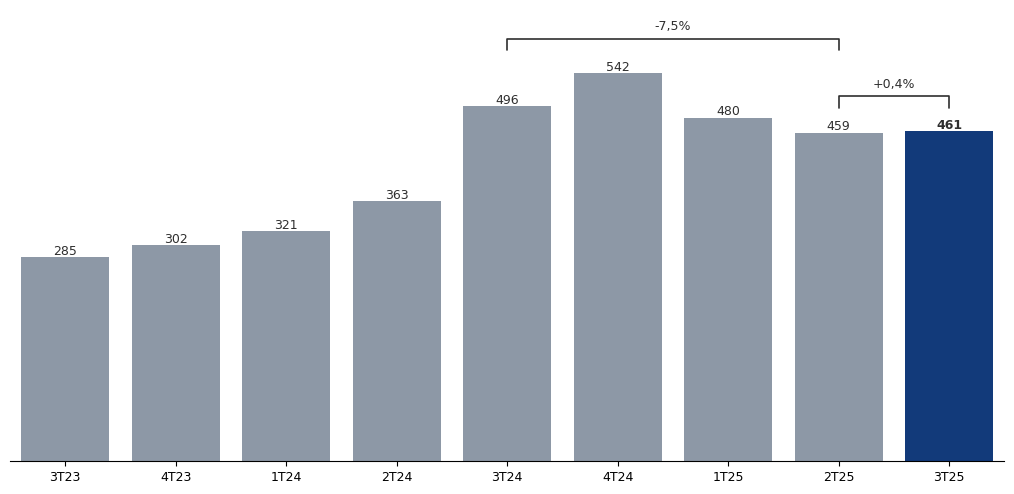

In [6]:
# 1) Gráfico barras: Trimestres (D:H)
plot_bar_from_excel(
    ExcelBarChartSpec(
        file_path=EXCEL_FILE,
        sheet_name="DRE Saida",
        values_range="C18:K18",
        xlabels_range="C3:K3",
        ylabel_cell="B18",
        title="Lucro Líquido - Trimestres",
        highlight_last=True,
        show_delta_pct=True,
        show_delta_bracket=True,
        # Lógica pedida: último vs penúltimo; penúltimo vs (penúltimo - 3)
        # (-2 vs -1) = 2T25 -> 3T25; (-5 vs -2) = 3T24 -> 2T25
        delta_pairs=((-2, -1), (-5, -2)),
        output_path="01_lucro_trimestres.png",
    )
)
plt.show()

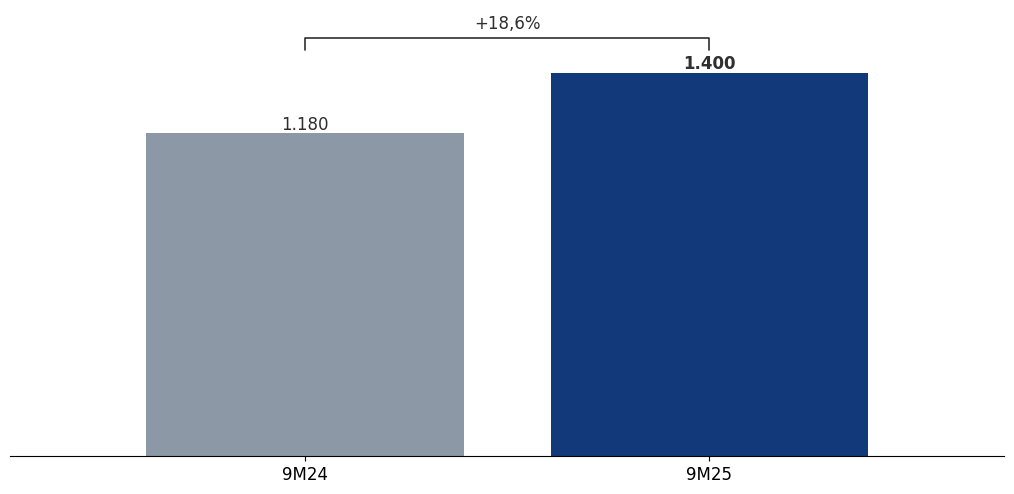

In [7]:
# 2) Gráfico barras: 9M (L:M)
plot_bar_from_excel(
    ExcelBarChartSpec(
        file_path=EXCEL_FILE,
        sheet_name="DRE Saida",
        values_range="L18:M18",
        xlabels_range="L3:M3",
        ylabel_cell="C18",
        title="Lucro Líquido - 9M",
        highlight_last=True,
        show_delta_pct=True,
        show_delta_bracket=True,
        # Força a mesma malha de "slots" do gráfico principal (C:K = 9 valores),
        # para as barras não ficarem visualmente largas demais com apenas 2 colunas.
        fixed_slot_count=9,
        output_path="02_lucro_9m.png",
    )
)
plt.show()

In [8]:
# 3) (Opcional) Linha ROE: Trimestres (ajuste o range do ROE no seu Excel)
plot_line_from_excel(
    file_path=EXCEL_FILE,
    sheet_name="DRE Saida",
    values_range="C20:K20",
    xlabels_range="C3:K3",
    title="ROE - Trimestres",
    output_path="03_roe_trimestres.png",
    fmt_as_percent=True,
    y_baseline=0.0,
    y_expand=0.10,
 )
plt.show()

ValueError: Valor não numérico no range: '9%'

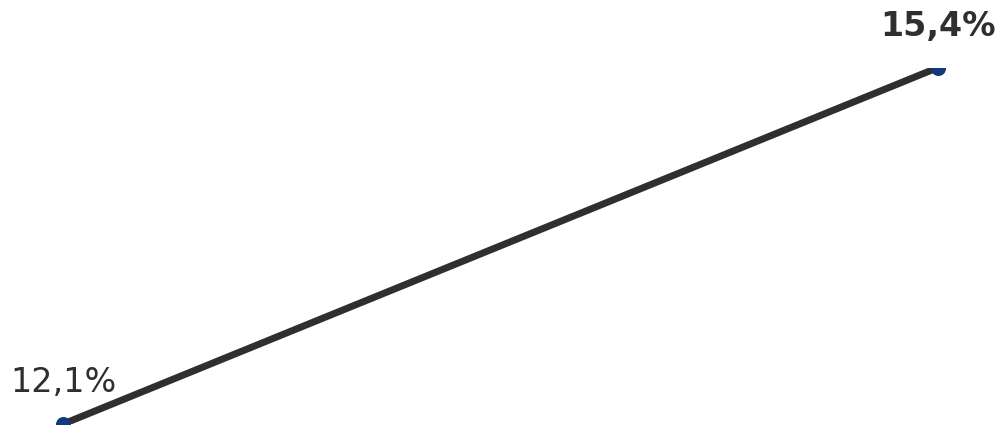

In [ ]:
# 4) (Opcional) Linha ROE: 9M (ajuste o range)
plot_line_from_excel(
    file_path=EXCEL_FILE,
    sheet_name="DRE Saida",
    values_range="L20:M20",
    xlabels_range="L3:M3",
    title="ROE - 9M",
    output_path="04_roe_9m.png",
    fmt_as_percent=True,
    # Ajuste pedido: fonte maior, linha mais grossa e ponto maior no 9M (2 pontos)
    line_width=5.0,
    label_fontsize=24.0,
    marker_size=96.0,
    label_offset_pts=18.0,
 )
plt.show()

## Qualidade (aba `Qualidade Cart 2682`)
Lê títulos em `B7:B10` e séries em `C7:P10` para gerar gráficos de linha.
- Varejo + Veículos no mesmo gráfico (Veículos tracejado).
- Demais linhas em gráficos separados.

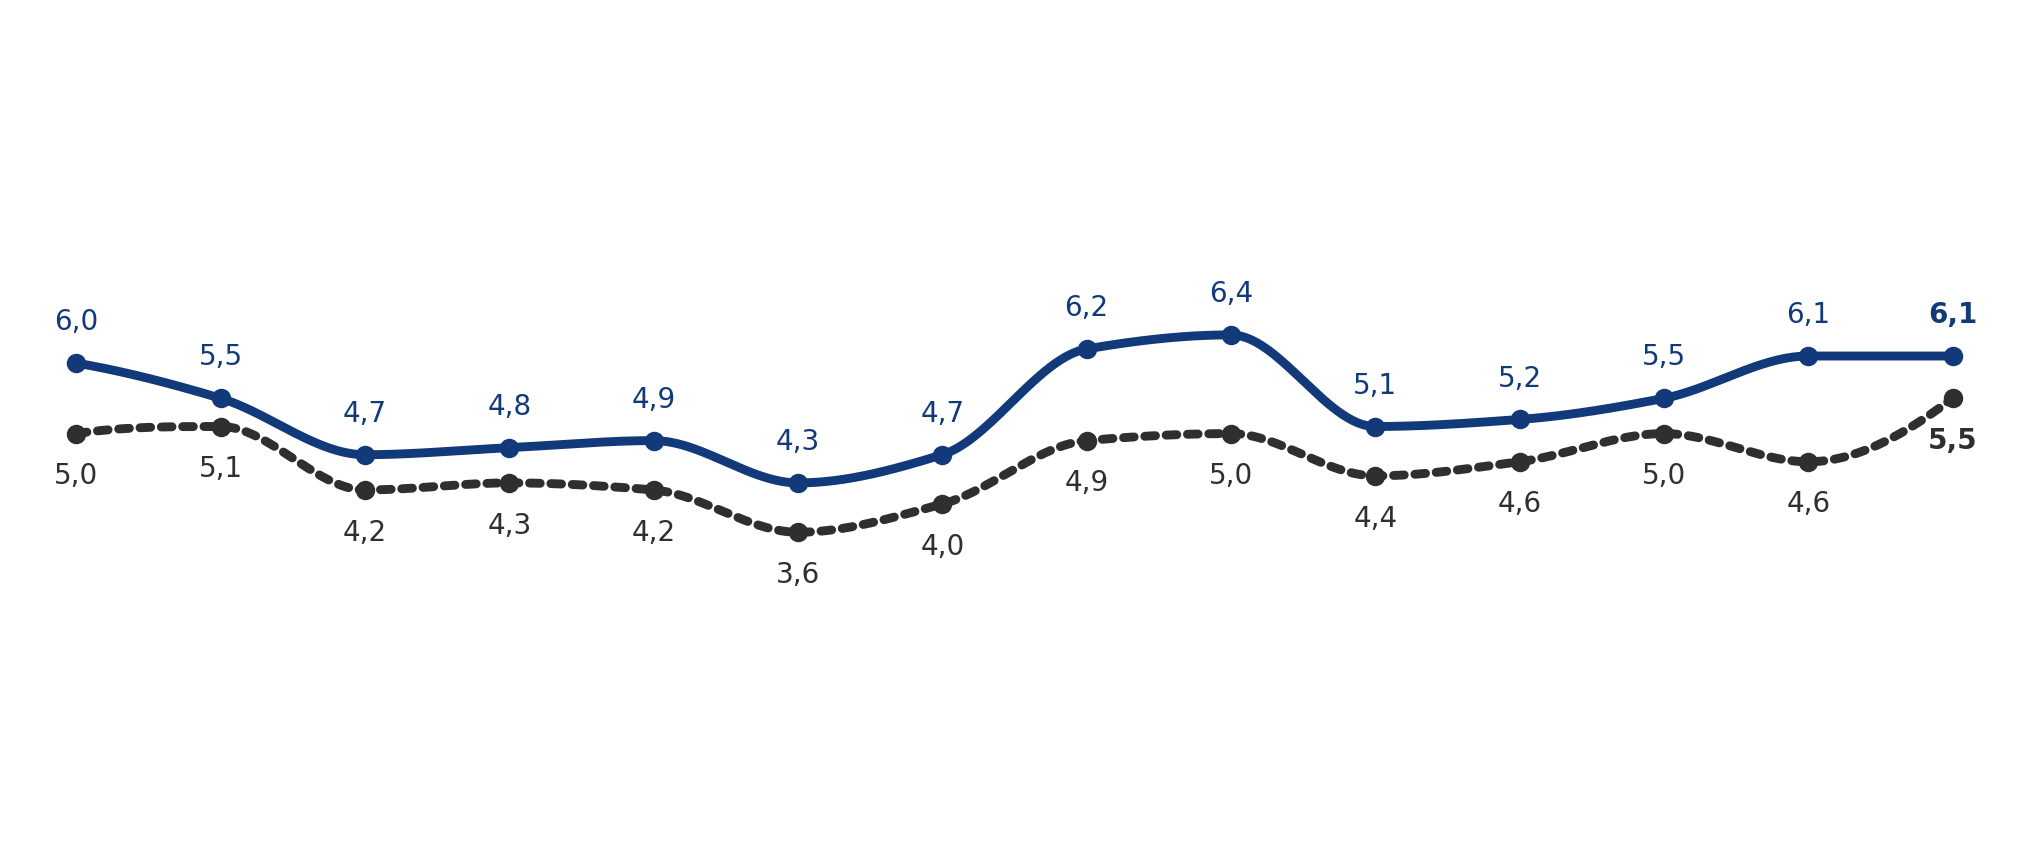

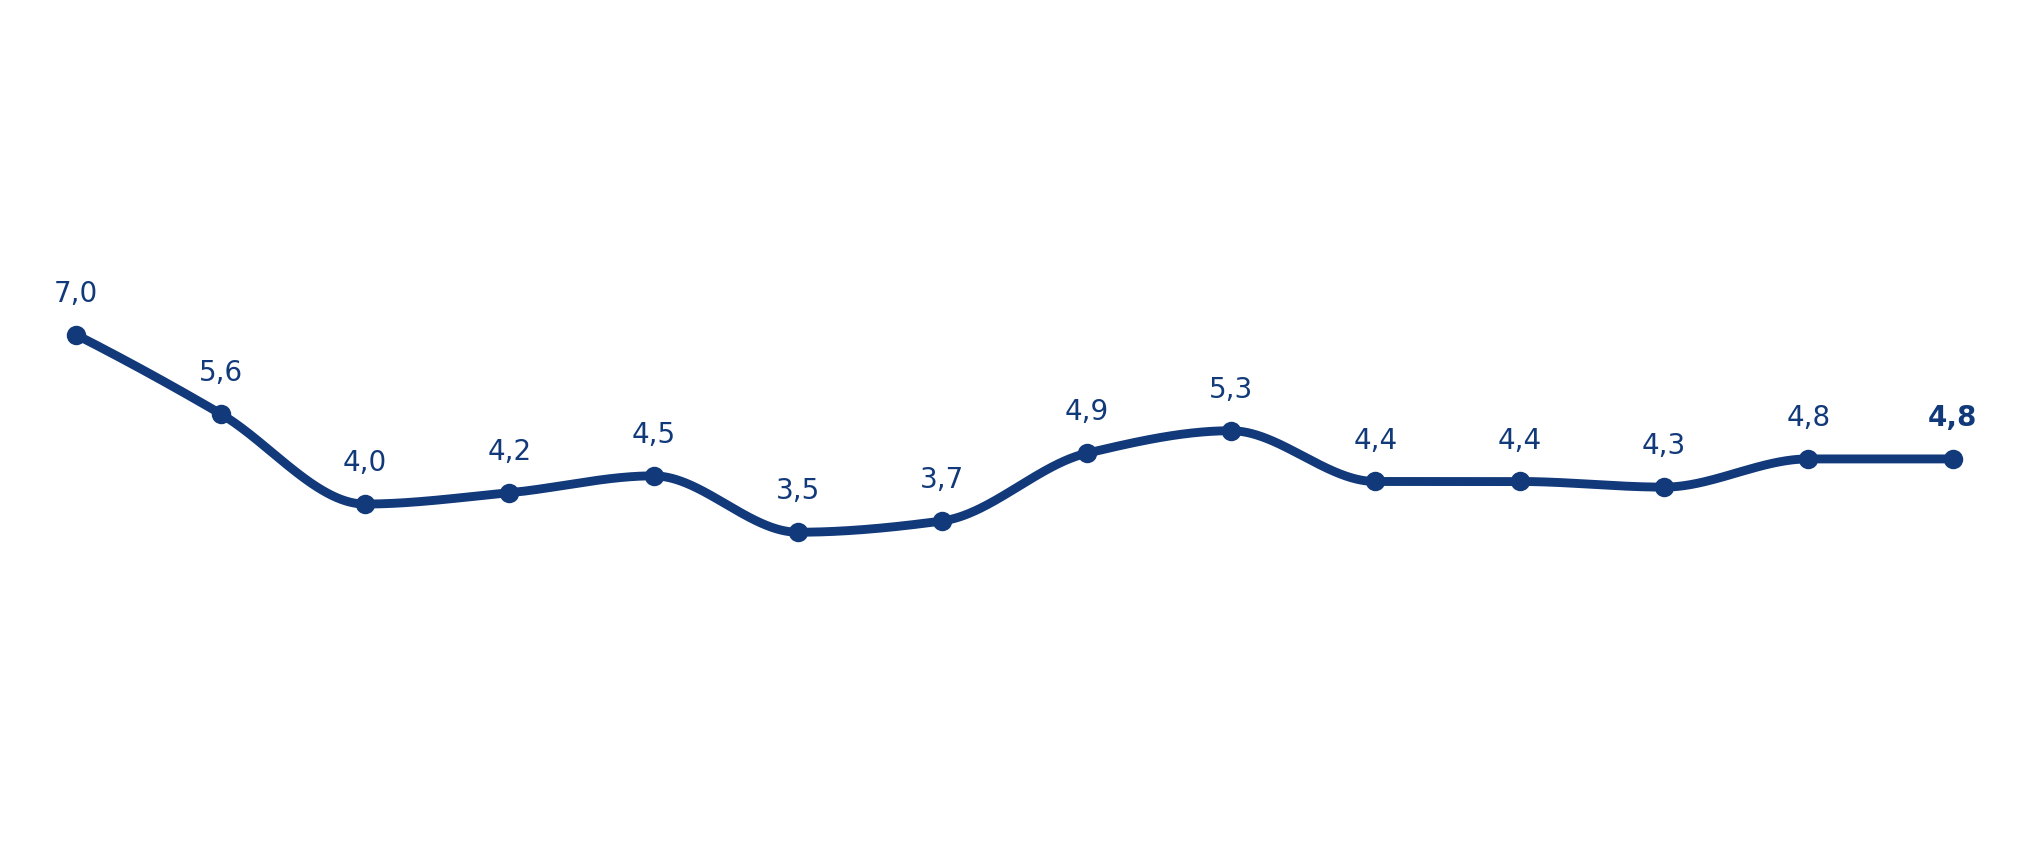

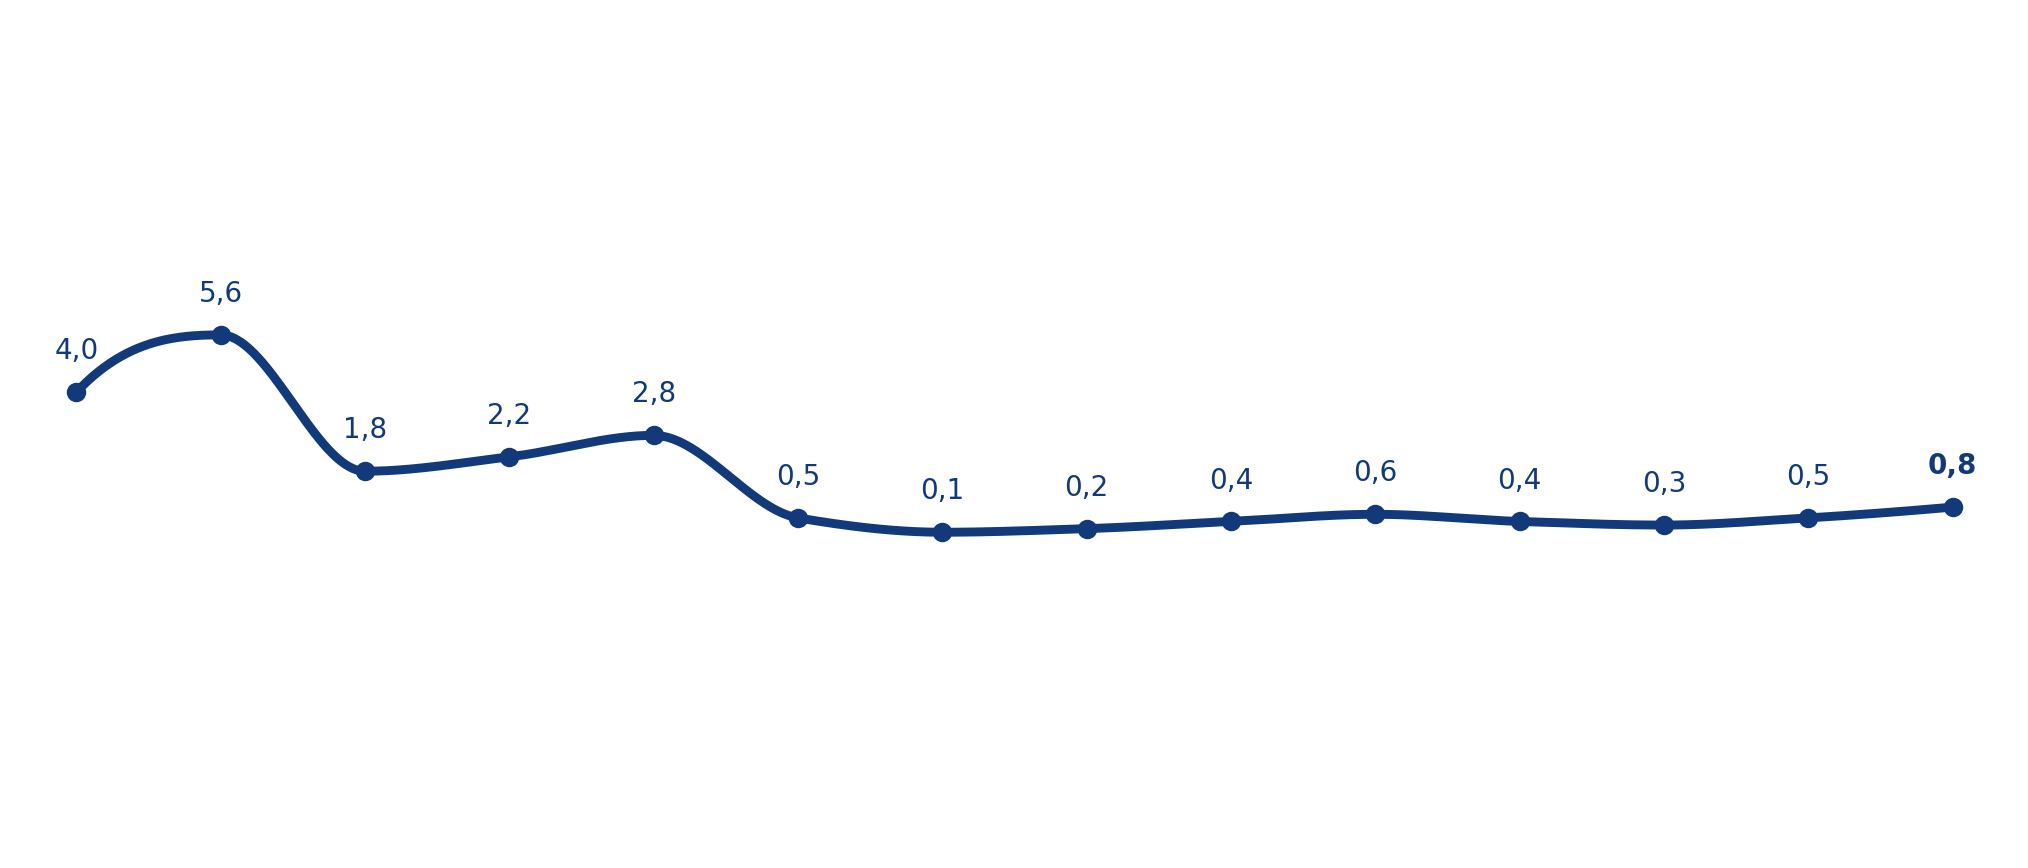

OK: Qualidade PNGs gerados:
 - 05_qualidade_varejo_veiculos.png
 - 06_qualidade_total.png
 - 07_qualidade_atacado.png


In [9]:
# Geração dos gráficos de Qualidade
from pathlib import Path
import re

def _sanitize_filename(s: str) -> str:
    s = (s or "").strip()
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"[^A-Za-z0-9_.-]", "", s)
    return s or "serie"

def _read_range_col(ws, cell_range: str):
    """Lê um range vertical (coluna) e retorna uma lista."""
    min_col, min_row, max_col, max_row = range_boundaries(cell_range)
    out = []
    for r in range(min_row, max_row + 1):
        for c in range(min_col, max_col + 1):
            out.append(ws.cell(row=r, column=c).value)
    return out

def plot_multi_line(
    *,
    xlabels: list[str],
    series: list[tuple[str, list[float], dict]],
    output_path: str,
    fmt_as_percent: bool = False,
    smooth: bool = True,
    smooth_points: int = 1400,
):
    """Plota 1..N séries no mesmo gráfico (transparente), com estilos por série.""" 
    x = np.arange(len(xlabels), dtype=float)
    fig, ax = plt.subplots(figsize=(10, 4.2), dpi=200)
    fig.patch.set_alpha(0)
    ax.set_facecolor("none")

    # Para “diminuir a diferença entre pontos” sem mexer nos valores,
    # a gente comprime a escala do Y adicionando mais padding no ylim.
    y_samples: list[float] = []

    for name, values, style in series:
        y = np.asarray(values, dtype=float)
        finite = np.isfinite(y)
        if finite.any():
            y_samples.extend([float(v) for v in y[finite]])

        color = style.get("color", "#2f2f2f")
        linestyle = style.get("linestyle", "-")
        line_width = float(style.get("line_width", 2.8))
        marker_color = style.get("marker_color", color)
        marker_size = float(style.get("marker_size", 36.0))
        show_markers = bool(style.get("show_markers", True))
        label_fontsize = float(style.get("label_fontsize", 10.0))
        label_offset_pts = float(style.get("label_offset_pts", 10.0))

        is_dashed = linestyle in ("--", "dashed")
        # Para ficar visualmente mais “suave”, use dashes bem curtos (quase pontilhado).
        dashes = style.get("dashes", (1.2, 1.2)) if is_dashed else None
        # Na série pontilhada (ex.: Veículos), os números ficam abaixo dos pontos.
        label_below = bool(style.get("label_below", False)) or is_dashed

        if smooth and len(values) >= 3:
            xs = np.linspace(x.min(), x.max(), num=max(int(smooth_points), len(values) * 120))
            ys = _pchip_interpolate(x, y, xs)
            (line,) = ax.plot(
                xs,
                ys,
                linewidth=line_width,
                color=color,
                linestyle=linestyle,
                zorder=2,
            )
        else:
            (line,) = ax.plot(
                x,
                y,
                linewidth=line_width,
                color=color,
                linestyle=linestyle,
                zorder=2,
            )

        # Setar estilos direto no Line2D tende a ser mais consistente
        line.set_antialiased(True)
        line.set_solid_joinstyle("round")
        line.set_solid_capstyle("round")
        try:
            line.set_dash_joinstyle("round")
            line.set_dash_capstyle("round")
        except Exception:
            pass
        try:
            line.set_snap(False)
        except Exception:
            pass

        if dashes is not None:
            try:
                line.set_dashes(dashes)
            except Exception:
                line.set_linestyle((0, dashes))

        if show_markers:
            ax.scatter(x, y, s=marker_size, color=marker_color, zorder=3)

        # Labels (último em negrito)
        last_idx = len(values) - 1
        for i, (xi, yi) in enumerate(zip(x, y)):
            label = f"{yi:.1f}%".replace(".", ",") if fmt_as_percent else str(yi).replace(".", ",")
            ax.annotate(
                label,
                (xi, yi),
                textcoords="offset points",
                xytext=(0, -abs(label_offset_pts) if label_below else abs(label_offset_pts)),
                ha="center",
                va="top" if label_below else "bottom",
                fontsize=label_fontsize,
                color=color,
                fontweight="bold" if i == last_idx else "normal",
                clip_on=False,
            )

    # Comprime o Y (mais espaço acima/abaixo => menos “queda” visual)
    if y_samples:
        y_min = min(y_samples)
        y_max = max(y_samples)
        y_range = max(1e-9, y_max - y_min)
        pad = y_range * 1.6  # aumente/diminua aqui se quiser mais/menos achatado
        ax.set_ylim(y_min - pad, y_max + pad)

    # Limpa eixos (estilo dos gráficos existentes)
    for s in ("left", "right", "top", "bottom"):
        ax.spines[s].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.grid(False)
    ax.margins(x=0.03)
    fig.tight_layout(pad=0.2)

    out = Path(output_path)
    out.parent.mkdir(parents=True, exist_ok=True)
    # DPI maior para reduzir serrilhado, especialmente em tracejado
    fig.savefig(out, dpi=450, transparent=True, bbox_inches="tight", pad_inches=0.08)
    return fig, ax


# --- Leitura da aba e geração ---
sheet_name = "Qualidade Cart 2682"
wb = load_workbook(filename=EXCEL_FILE, data_only=True)
if sheet_name not in wb.sheetnames:
    raise ValueError(f"Aba não encontrada: {sheet_name!r}. Disponíveis: {wb.sheetnames}")
ws = wb[sheet_name]

# Títulos / nomes das séries (vertical em B7:B10)
raw_titles = _read_range_col(ws, "B7:B10")
titles = [("" if v is None else str(v)).strip() for v in raw_titles]

# X labels: assumimos que os períodos estão na linha 6 (C6:P6).
# Se estiverem em outra linha, ajuste aqui para C?:P?
raw_x = _read_range_row(ws, "C6:P6")
xlabels = [("" if v is None else str(v)).strip() for v in raw_x]
if not any(xlabels):
    # Fallback: usa índices 1..N
    xlabels = [str(i + 1) for i in range(len(raw_x))]

# Séries: C7:P10 (4 linhas)
values_rows = []
for r in range(7, 11):
    rng = f"C{r}:P{r}"
    values_rows.append(_to_float_list(_read_range_row(ws, rng)))

# Mapeia nomes (se vazio, gera nome padrão)
def _name(i: int) -> str:
    t = titles[i] if i < len(titles) else ""
    return t if t else f"serie{i+1}"

# 1) Varejo + Veículos juntos (Veículos tracejado)
# Em vez de assumir posição fixa, tenta detectar pelo texto do título.
def _find_title_index(*keywords: str) -> int | None:
    kws = [k.lower() for k in keywords if k]
    for idx, t in enumerate(titles):
        tl = (t or "").lower()
        if any(k in tl for k in kws):
            return idx
    return None

idx_varejo = _find_title_index("varejo")
idx_veiculos = _find_title_index("veic")  # cobre "veículo(s)" / "veiculos"

# Fallback seguro se não achou (mantém comportamento anterior)
if idx_varejo is None or idx_veiculos is None or idx_varejo == idx_veiculos:
    idx_varejo, idx_veiculos = 0, 1

skip_indices = {idx_varejo, idx_veiculos}

output_files: list[str] = []
seq_num = 5  # 05, 06, 07...
def _seq_prefix() -> str:
    global seq_num
    p = f"{seq_num:02d}"
    seq_num += 1
    return p

series_combo = [
    (_name(idx_varejo), values_rows[idx_varejo], {"color": "#123a7a", "linestyle": "-", "line_width": 3.2}),
    (_name(idx_veiculos), values_rows[idx_veiculos], {"color": "#2f2f2f", "linestyle": "--", "line_width": 3.2, "dashes": (1.2, 1.2)}),
]
prefix = _seq_prefix()
plot_multi_line(
    xlabels=xlabels,
    series=series_combo,
    output_path=f"{prefix}_qualidade_varejo_veiculos.png",
    fmt_as_percent=False,
    smooth=True,
)
plt.show()
output_files.append(f"{prefix}_qualidade_varejo_veiculos.png")

# 2) Demais séries separadas
for i in range(len(values_rows)):
    if i in skip_indices:
        continue
    name = _name(i)
    prefix = _seq_prefix()
    filename = f"{prefix}_qualidade_{_sanitize_filename(name).lower()}.png"
    plot_multi_line(
        xlabels=xlabels,
        series=[(name, values_rows[i], {"color": "#123a7a", "linestyle": "-", "line_width": 3.2})],
        output_path=filename,
        fmt_as_percent=False,
        smooth=True,
    )
    plt.show()
    output_files.append(filename)

print("OK: Qualidade PNGs gerados:")
for f in output_files:
    print(f" - {f}")


## Empréstimos (aba `Emprestimos`)
Lê períodos em `D4:F4`, categorias em `C5:C9` e valores em `D5:F9`.
- Regra: `Consignado + Demais` são somados e viram apenas `Demais`.
- Gráfico: barras empilhadas (stacked) com fundo transparente.

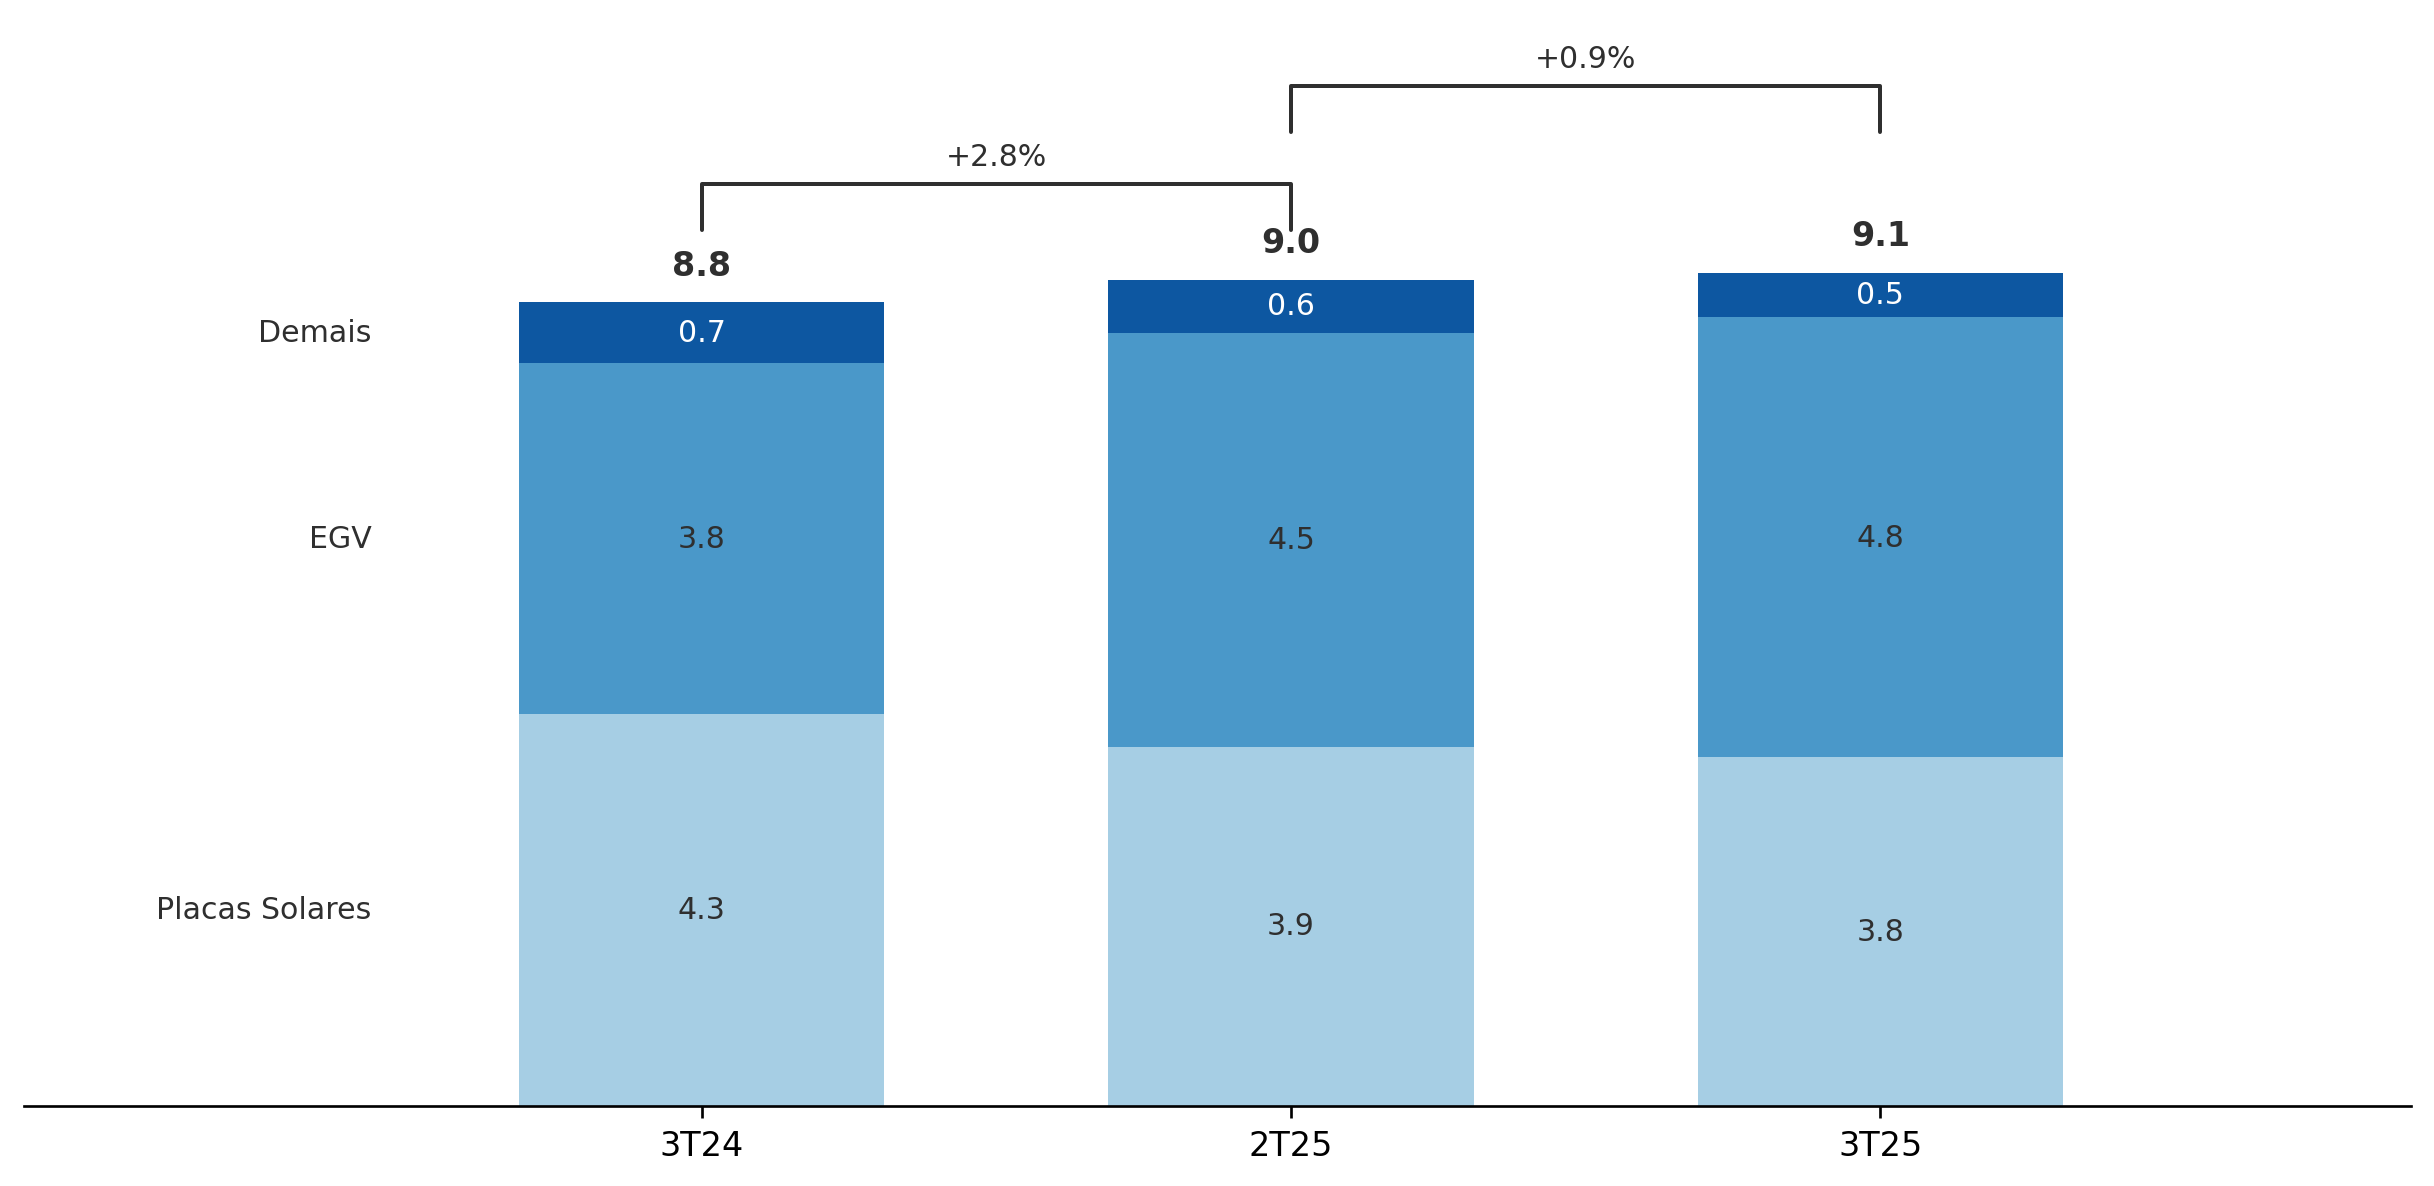

In [10]:
# Geração do gráfico empilhado de Empréstimos
from pathlib import Path

def _normalize_label(s: str) -> str:
    return (s or "").strip().lower()

def _read_range_col(ws, cell_range: str):
    """Lê um range vertical (coluna) e retorna uma lista."""
    min_col, min_row, max_col, max_row = range_boundaries(cell_range)
    out = []
    for r in range(min_row, max_row + 1):
        for c in range(min_col, max_col + 1):
            out.append(ws.cell(row=r, column=c).value)
    return out

def _fmt_number(v: float) -> str:
    # Formato pedido: X.X (usa ponto como separador decimal)
    try:
        return f"{float(v):.1f}"
    except Exception:
        return str(v)

def _is_total_row(label: str) -> bool:
    key = _normalize_label(label)
    # A linha 'Total' não deve ser plotada como segmento; apenas como número no topo.
    return key == "total" or key.startswith("total ")

def _read_emprestimos_table(*, xlsx_path: str | Path):
    xlsx_path = Path(xlsx_path)
    wb = load_workbook(filename=xlsx_path, data_only=True)
    sheet_name = "Emprestimos"
    if sheet_name not in wb.sheetnames:
        raise ValueError(f"Aba não encontrada: {sheet_name!r}. Disponíveis: {wb.sheetnames}")
    ws = wb[sheet_name]

    # Períodos (eixo X)
    raw_x = _read_range_row(ws, "D4:F4")
    xlabels = [("" if v is None else str(v)).strip() for v in raw_x]
    if not any(xlabels):
        xlabels = ["1", "2", "3"]

    # Categorias (segmentos)
    raw_cats = _read_range_col(ws, "C5:C9")
    cat_labels = [("" if v is None else str(v)).strip() for v in raw_cats]

    # Valores por categoria (D..F)
    rows: list[tuple[str, list[float]]] = []
    for r, label in zip(range(5, 10), cat_labels):
        if _is_total_row(label):
            # ignora linha 'Total' como segmento do empilhado
            continue
        vals = _to_float_list(_read_range_row(ws, f"D{r}:F{r}"))
        rows.append((label, vals))

    return xlabels, rows

def _combine_consignado_demais(rows: list[tuple[str, list[float]]]) -> list[tuple[str, list[float]]]:
    consignado: list[float] | None = None
    demais: list[float] | None = None
    out: list[tuple[str, list[float]]] = []

    for label, vals in rows:
        key = _normalize_label(label)
        if "consign" in key:
            consignado = vals
            continue
        if key == "demais" or "demais" in key:
            demais = vals
            continue
        out.append((label, vals))

    if consignado is None and demais is None:
        return rows

    # Regras: se tiver os dois, soma e chama de 'Demais'; se tiver só consignado, vira 'Demais'
    if demais is None:
        demais = [0.0] * len(consignado or [])
    if consignado is None:
        consignado = [0.0] * len(demais or [])

    merged = [float(d) + float(c) for d, c in zip(demais, consignado)]
    out.append(("Demais", merged))
    return out

def _text_color_for_bg_rgba(rgba) -> str:
    # Escolhe branco/preto para contraste com o segmento
    r, g, b = float(rgba[0]), float(rgba[1]), float(rgba[2])
    # luminância relativa (aprox.)
    lum = 0.2126 * r + 0.7152 * g + 0.0722 * b
    return "#ffffff" if lum < 0.50 else "#2f2f2f"

def plot_emprestimos_stacked(
    *,
    xlabels: list[str],
    rows: list[tuple[str, list[float]]],
    output_path: str | None = None,
    title: str | None = None,
    show_segment_labels_left: bool = True,
    show_values_inside: bool = True,
    left_label_margin_slots: float = 1.10,
    show_delta_pct: bool = True,
    show_delta_bracket: bool = True,
    dpi: int = 220,
    figsize=(10, 4.8),
):
    n = len(xlabels)
    x = np.arange(n, dtype=float)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    # Fundo transparente (figura + área do plot)
    fig.patch.set_facecolor("none")
    fig.patch.set_alpha(0)
    ax.set_facecolor("none")
    try:
        ax.patch.set_alpha(0)
    except Exception:
        pass

    # Paleta "similar" aos gráficos anteriores: variações de azul via colormap
    cmap = plt.cm.Blues
    colors = [cmap(v) for v in np.linspace(0.35, 0.85, num=max(1, len(rows)))]

    bar_width = 0.62
    bottom = np.zeros(n, dtype=float)
    segment_bottoms: list[np.ndarray] = []
    segment_values: list[np.ndarray] = []
    segment_labels: list[str] = []

    for (label, vals), color in zip(rows, colors):
        y = np.asarray(vals, dtype=float)
        segment_labels.append(label)
        segment_bottoms.append(bottom.copy())
        segment_values.append(y.copy())
        ax.bar(x, y, bottom=bottom, color=color, edgecolor="none", width=bar_width)
        bottom = bottom + np.nan_to_num(y, nan=0.0)

    # “Labels” das categorias só 1x no lado esquerdo (usando o primeiro período com valor > 0)
    if show_segment_labels_left and rows:
        ax.set_xlim(x.min() - float(left_label_margin_slots), x.max() + 0.9)
        x_label = x.min() - (bar_width / 2.0 + 0.25)
        for j, label in enumerate(segment_labels):
            # acha um ponto de referência (primeira barra com valor não-zero)
            y_center_ref = None
            for i in range(n):
                val = float(segment_values[j][i]) if i < segment_values[j].size else 0.0
                if np.isfinite(val) and abs(val) > 1e-12:
                    y_center_ref = float(segment_bottoms[j][i]) + val / 2.0
                    break
            if y_center_ref is None:
                continue
            ax.text(
                x_label,
                y_center_ref,
                str(label),
                ha="right",
                va="center",
                fontsize=9,
                color="#2f2f2f",
                clip_on=False,
            )

    # Valores no meio de cada “box” (cada segmento, em cada barra)
    if show_values_inside and rows:
        for i in range(n):
            for j, color in enumerate(colors):
                val = float(segment_values[j][i]) if i < segment_values[j].size else 0.0
                if not np.isfinite(val) or abs(val) < 1e-12:
                    continue
                y_center = float(segment_bottoms[j][i]) + val / 2.0
                ax.text(
                    float(x[i]),
                    y_center,
                    _fmt_number(val),
                    ha="center",
                    va="center",
                    fontsize=9,
                    color=_text_color_for_bg_rgba(color),
                )

    # Total: NÃO é uma barra/segmento; apenas o número acima de cada barra
    totals = bottom.copy()
    for i in range(n):
        total = float(totals[i])
        if not np.isfinite(total):
            continue
        ax.annotate(
            _fmt_number(total),
            (x[i], total),
            textcoords="offset points",
            xytext=(0, 6),
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
            color="#2f2f2f",
            clip_on=False,
            zorder=6,
        )

    # Ganho/variação de um trimestre para outro (linhas conectando as barras)
    delta_label_top: float | None = None
    if show_delta_pct and n >= 2:
        vals = np.asarray(totals, dtype=float)
        abs_max = float(np.nanmax(np.abs(vals))) if np.isfinite(np.nanmax(np.abs(vals))) else 0.0
        offset_y = max(abs_max * 0.06, 0.5)
        bracket_h = max(abs_max * 0.03, 0.5)

        # Modo anterior: empilha os brackets em níveis diferentes
        for level, i in enumerate(range(1, n)):
            prev = float(vals[i - 1])
            curr = float(vals[i])
            if not np.isfinite(prev) or not np.isfinite(curr) or prev == 0:
                continue
            pct = (curr / prev - 1.0) * 100.0
            label = f"{pct:+.1f}%"

            x1 = float(x[i - 1])
            x2 = float(x[i])
            top = max(prev, curr)
            y_anchor = top + offset_y + level * (bracket_h + offset_y * 0.9)

            if show_delta_bracket:
                ax.plot(
                    [x1, x1, x2, x2],
                    [y_anchor, y_anchor + bracket_h, y_anchor + bracket_h, y_anchor],
                    color="#2f2f2f",
                    linewidth=1.2,
                    solid_capstyle="round",
                    zorder=4,
                )
                text_y = y_anchor + bracket_h + offset_y * 0.25
            else:
                # Linha simples conectando os topos
                ax.plot(
                    [x1, x2],
                    [prev + offset_y, curr + offset_y],
                    color="#2f2f2f",
                    linewidth=1.2,
                    solid_capstyle="round",
                    zorder=4,
                )
                text_y = top + offset_y * 1.15

            ax.text(
                (x1 + x2) / 2.0,
                text_y,
                label,
                ha="center",
                va="bottom",
                fontsize=9,
                color="#2f2f2f",
                zorder=5,
                clip_on=False,
            )
            delta_label_top = text_y if delta_label_top is None else max(delta_label_top, text_y)

        if delta_label_top is not None:
            cur_ymin, cur_ymax = ax.get_ylim()
            ax.set_ylim(cur_ymin, max(cur_ymax, delta_label_top + offset_y))

    # Estilo parecido com os gráficos existentes
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=0, fontsize=10)
    ax.set_yticks([])
    for s in ("left", "right", "top"):
        ax.spines[s].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.tick_params(axis="y", left=False, labelleft=False)
    ax.grid(False)
    ax.margins(x=0.02, y=0.10)
    ax.set_title("") if title is None else ax.set_title(title)

    fig.tight_layout(pad=0.2)

    if output_path:
        out = Path(output_path)
        out.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(
            out,
            dpi=int(dpi),
            transparent=True,
            facecolor="none",
            edgecolor="none",
            bbox_inches="tight",
            pad_inches=0.06,
        )

    return fig, ax

# --- Execução ---
xlabels_emp, rows_emp = _read_emprestimos_table(xlsx_path=EXCEL_FILE)
rows_emp2 = _combine_consignado_demais(rows_emp)

plot_emprestimos_stacked(
    xlabels=xlabels_emp,
    rows=rows_emp2,
    output_path="08_emprestimos_empilhado.png",
    title=None,
    show_segment_labels_left=True,
    show_values_inside=True,
    left_label_margin_slots=1.15,
    show_delta_pct=True,
    show_delta_bracket=True,
    dpi=240,
    figsize=(10, 4.8),
 )
plt.show()

## Seguros e Cartões (aba `Seguros e Cartoes`)
Barras simples usando os valores da linha 15 (`D15:F15`) e rótulos do eixo X em `D14:F14`.
- Mostra apenas barras, valores no topo e brackets de variação % entre períodos.

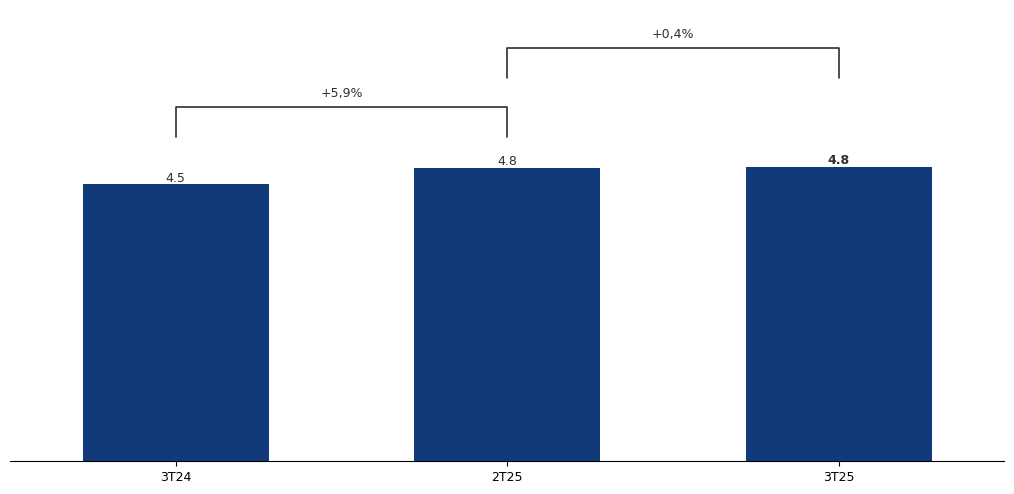

In [11]:
# Gráfico de barras (Total Cartões) com brackets
plot_bar_from_excel(
    ExcelBarChartSpec(
        file_path=EXCEL_FILE,
        sheet_name="Seguros e Cartoes",
        # Linha 15: C15 é texto ('Total'); os números estão em D..F
        values_range="D15:F15",
        xlabels_range="D14:F14",
        # Pedido: todas as barras em azul escuro
        bar_color="#123a7a",
        show_delta_pct=True,
        show_delta_bracket=True,
        # Pedido: mais precisão no topo + barras 30% mais finas
        value_decimals=1,
        bar_width_scale=0.70,
        output_path="09_seguros_cartoes_total.png",
    )
)
plt.show()

## Gráfico de Pizza (Donut Chart)
Explorando os dados da worksheet "Pizza Teste" para criar gráficos de pizza com centro oco.

In [12]:
# Carrega a worksheet "Pizza Teste" e explora os dados
ws_pizza = wb["Pizza Teste"]

# Lê os dados da área A1:D999 (mas vamos primeiro ver o que tem)
print("Explorando worksheet 'Pizza Teste':")
print("-" * 50)

# Vamos ver as primeiras linhas para entender a estrutura
for row in range(1, 20):  # Primeiras 20 linhas
    row_data = []
    for col in range(1, 5):  # Colunas A-D
        cell_value = ws_pizza.cell(row=row, column=col).value
        row_data.append(cell_value)
    if any(v is not None for v in row_data):  # Só mostra linhas com dados
        print(f"Linha {row}: {row_data}")

Explorando worksheet 'Pizza Teste':
--------------------------------------------------
Linha 1: [None, 'Carteira de Crédito', 'Valor(bi)', 'Porcentagem']
Linha 2: ['Veiculos Leves', 'Veiculos Leves Usados', 44.495999999999995, 0.47999999999999987]
Linha 3: ['Atacado', 'Corporate', 13.904999999999998, 0.14999999999999994]
Linha 4: ['Atacado', 'Large e Instituições Financeiras', 10.197, 0.10999999999999997]
Linha 5: ['Growth', 'Demais', 0.9269999999999999, 0.009999999999999997]
Linha 6: ['Growth', 'PME', 2.7809999999999997, 0.029999999999999992]
Linha 7: ['Growth', 'EGV', 4.635, 0.04999999999999999]
Linha 8: ['Growth', 'Cartões', 4.635, 0.04999999999999999]
Linha 9: ['Growth', 'Painéis Solares', 3.7079999999999997, 0.03999999999999999]
Linha 10: ['Growth', 'Motos, Pesados e Novos', 7.4159999999999995, 0.07999999999999997]
Linha 11: [None, None, None, 0]
Linha 12: [None, None, None, 0]
Linha 13: [None, None, None, 0]
Linha 14: [None, None, None, 0]
Linha 15: [None, None, None, 0]
Linha 16

In [13]:
# Extrai os dados da worksheet para listas
labels = []
values = []
percentages = []
categories = []

for row in range(2, 11):  # Linhas 2-10 (dados)
    category = ws_pizza.cell(row=row, column=1).value
    label = ws_pizza.cell(row=row, column=2).value
    value = ws_pizza.cell(row=row, column=3).value
    pct = ws_pizza.cell(row=row, column=4).value
    
    if label is not None:
        categories.append(category)
        labels.append(label)
        values.append(value if value else 0)
        percentages.append(pct if pct else 0)

print("Labels:", labels)
print("Values (bi):", values)
print("Percentages:", [f"{p*100:.1f}%" for p in percentages])
print("Categories:", categories)
print(f"\nTotal: R$ {sum(values):.1f} bi")

Labels: ['Veiculos Leves Usados', 'Corporate', 'Large e Instituições Financeiras', 'Demais', 'PME', 'EGV', 'Cartões', 'Painéis Solares', 'Motos, Pesados e Novos']
Values (bi): [44.495999999999995, 13.904999999999998, 10.197, 0.9269999999999999, 2.7809999999999997, 4.635, 4.635, 3.7079999999999997, 7.4159999999999995]
Percentages: ['48.0%', '15.0%', '11.0%', '1.0%', '3.0%', '5.0%', '5.0%', '4.0%', '8.0%']
Categories: ['Veiculos Leves', 'Atacado', 'Atacado', 'Growth', 'Growth', 'Growth', 'Growth', 'Growth', 'Growth']

Total: R$ 92.7 bi


In [14]:
def plot_donut_chart(labels, values, center_text, title=None, colors=None, figsize=(8, 8)):
    """
    Plota um gráfico de pizza com centro oco (donut).

    :param labels: lista de rótulos
    :param values: lista de valores numéricos
    :param center_text: texto exibido no centro
    :param title: título do gráfico
    :param colors: lista de cores (opcional)
    :param figsize: tamanho da figura
    """
    fig, ax = plt.subplots(figsize=figsize)

    wedges, texts, autotexts = ax.pie(
        values,
        labels=labels,
        autopct="%1.1f%%",
        startangle=90,
        counterclock=False,
        colors=colors,
        wedgeprops=dict(width=0.35, edgecolor="white"),
        textprops=dict(color="black", fontsize=10),
        pctdistance=0.8,
        labeldistance=1.1,
    )

    # Texto central
    ax.text(
        0,
        0,
        center_text,
        ha="center",
        va="center",
        fontsize=12,
        fontweight="bold",
        linespacing=1.5,
    )

    if title:
        ax.set_title(title, fontsize=14, pad=20)

    ax.axis("equal")
    plt.tight_layout()
    return fig, ax

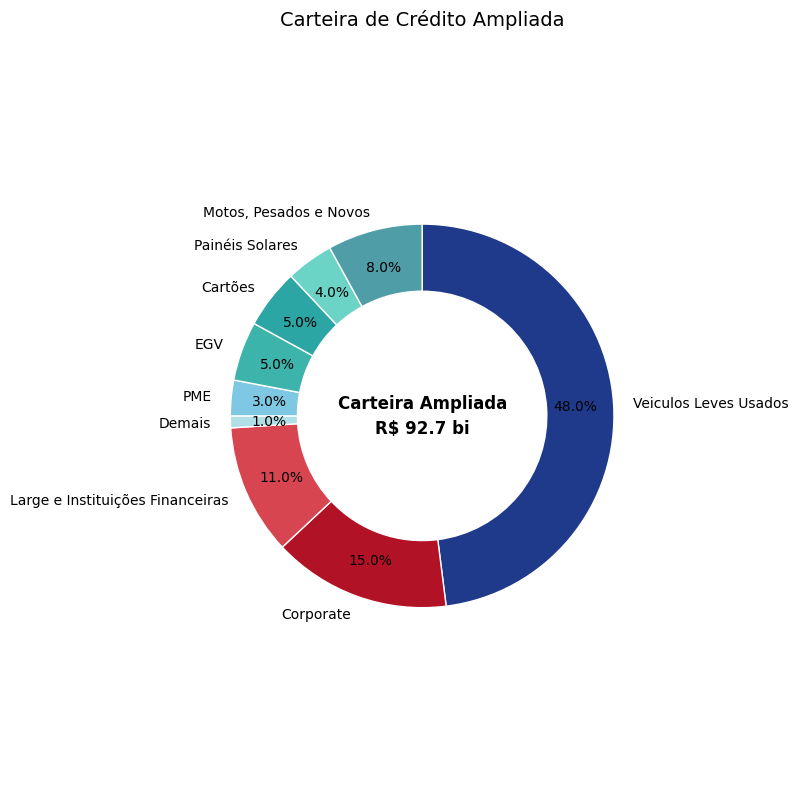

In [15]:
# Paleta de cores para o gráfico (baseada nas categorias)
colors = [
    "#1f3a8a",  # azul escuro - Veículos Leves
    "#b11226",  # vermelho - Atacado (Corporate)
    "#d64550",  # vermelho claro - Atacado (Large)
    "#b0dfe5",  # azul claro - Growth (Demais)
    "#7ec8e3",  # azul médio - Growth (PME)  
    "#3cb4ac",  # verde água - Growth (EGV)
    "#2ca6a4",  # verde água escuro - Growth (Cartões)
    "#6bd4c6",  # verde claro - Growth (Painéis)
    "#4f9da6",  # azul esverdeado - Growth (Motos)
]

# Texto central com informações do total
total_value = sum(values)
center_text = f"Carteira Ampliada\nR$ {total_value:.1f} bi"

# Plotar o gráfico
fig, ax = plot_donut_chart(
    labels=labels,
    values=values,
    center_text=center_text,
    title="Carteira de Crédito Ampliada",
    colors=colors,
)
plt.show()

In [16]:
# Agrupa os dados por categoria para o anel externo
from collections import OrderedDict

category_totals = OrderedDict()
for cat, val in zip(categories, values):
    category_totals[cat] = category_totals.get(cat, 0) + val

cat_labels = list(category_totals.keys())
cat_values = list(category_totals.values())
cat_percentages = [v / sum(cat_values) * 100 for v in cat_values]

print("Categorias agregadas:")
for label, val, pct in zip(cat_labels, cat_values, cat_percentages):
    print(f"  {label}: R$ {val:.1f} bi ({pct:.1f}%)")

Categorias agregadas:
  Veiculos Leves: R$ 44.5 bi (48.0%)
  Atacado: R$ 24.1 bi (26.0%)
  Growth: R$ 24.1 bi (26.0%)


In [17]:
def plot_nested_donut_chart(
    inner_labels, inner_values, 
    outer_labels, outer_values,
    center_text, title=None, 
    inner_colors=None, outer_colors=None,
    figsize=(10, 10)
):
    """
    Plota um gráfico de donut com dois anéis:
    - Anel externo: categorias agregadas
    - Anel interno: detalhes por subcategoria
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Anel EXTERNO (categorias) - maior raio
    outer_wedges, outer_texts, outer_autotexts = ax.pie(
        outer_values,
        labels=outer_labels,
        autopct=lambda pct: f'{pct:.0f}%',
        startangle=90,
        counterclock=False,
        colors=outer_colors,
        wedgeprops=dict(width=0.25, edgecolor="white", linewidth=2),
        textprops=dict(color="black", fontsize=11, fontweight="bold"),
        pctdistance=0.85,
        labeldistance=1.08,
        radius=1.0,
    )
    
    # Anel INTERNO (detalhes) - menor raio
    inner_wedges, inner_texts, inner_autotexts = ax.pie(
        inner_values,
        labels=None,  # Sem labels no interno para não poluir
        autopct=lambda pct: f'{pct:.0f}%' if pct >= 5 else '',
        startangle=90,
        counterclock=False,
        colors=inner_colors,
        wedgeprops=dict(width=0.30, edgecolor="white", linewidth=1),
        textprops=dict(color="white", fontsize=8),
        pctdistance=0.75,
        radius=0.70,
    )
    
    # Texto central
    ax.text(
        0, 0, center_text,
        ha="center", va="center",
        fontsize=13, fontweight="bold",
        linespacing=1.5,
    )
    
    # Legenda para os itens internos
    ax.legend(
        inner_wedges, inner_labels,
        title="Detalhamento",
        loc="center left",
        bbox_to_anchor=(1.0, 0.5),
        fontsize=9,
    )
    
    if title:
        ax.set_title(title, fontsize=14, fontweight="bold", pad=20)
    
    ax.axis("equal")
    plt.tight_layout()
    return fig, ax

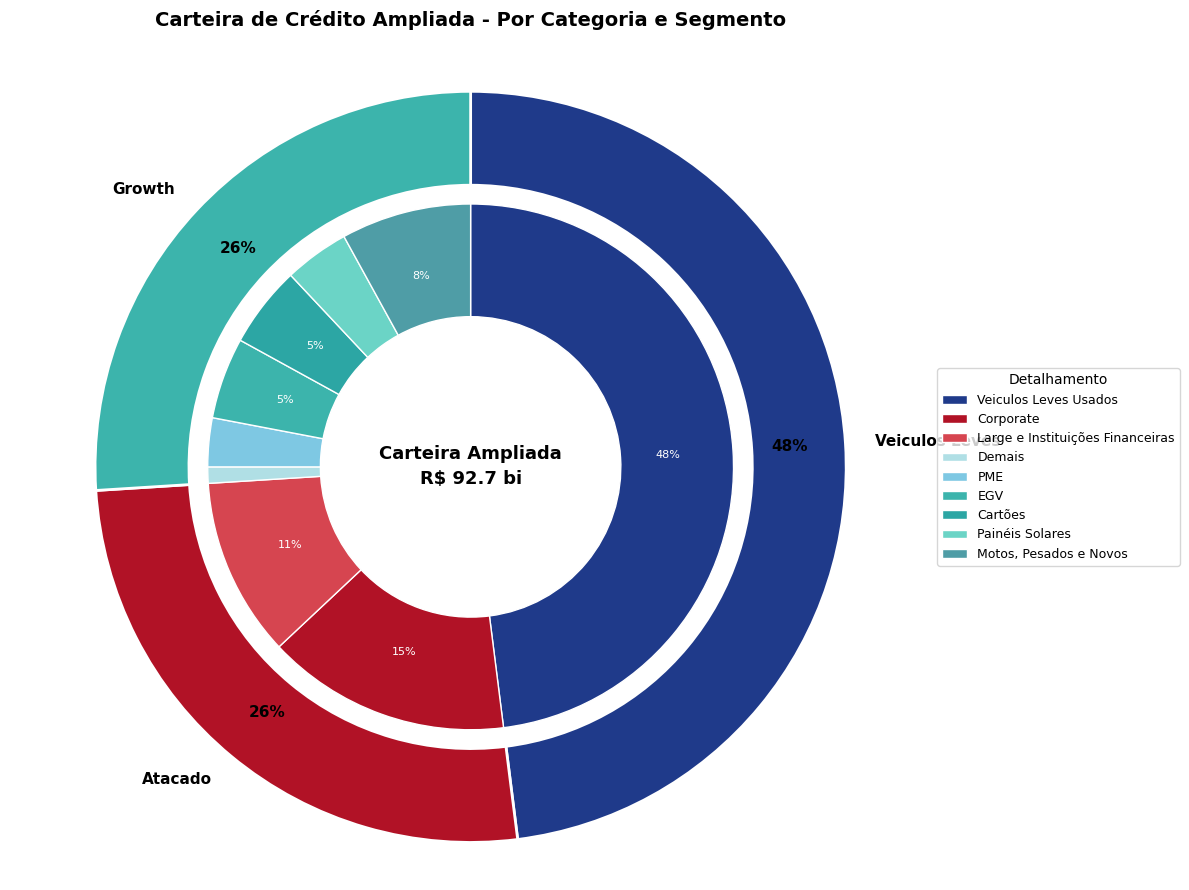

In [18]:
# Cores para o anel interno (detalhes) - tons variados por categoria
inner_colors = [
    "#1f3a8a",  # Veículos Leves Usados (azul escuro)
    "#b11226",  # Corporate (vermelho)
    "#d64550",  # Large e Instituições (vermelho claro)
    "#b0dfe5",  # Demais (azul bem claro)
    "#7ec8e3",  # PME (azul claro)
    "#3cb4ac",  # EGV (verde água)
    "#2ca6a4",  # Cartões (verde água escuro)
    "#6bd4c6",  # Painéis Solares (verde claro)
    "#4f9da6",  # Motos, Pesados e Novos (azul esverdeado)
]

# Cores para o anel externo (categorias) - cores principais de cada grupo
outer_colors = [
    "#1f3a8a",  # Veículos Leves - azul escuro
    "#b11226",  # Atacado - vermelho
    "#3cb4ac",  # Growth - verde água
]

# Texto central
center_text = f"Carteira Ampliada\nR$ {total_value:.1f} bi"

# Plotar o gráfico com dois anéis
fig, ax = plot_nested_donut_chart(
    inner_labels=labels,
    inner_values=values,
    outer_labels=cat_labels,
    outer_values=cat_values,
    center_text=center_text,
    title="Carteira de Crédito Ampliada - Por Categoria e Segmento",
    inner_colors=inner_colors,
    outer_colors=outer_colors,
    figsize=(12, 9),
)
plt.show()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


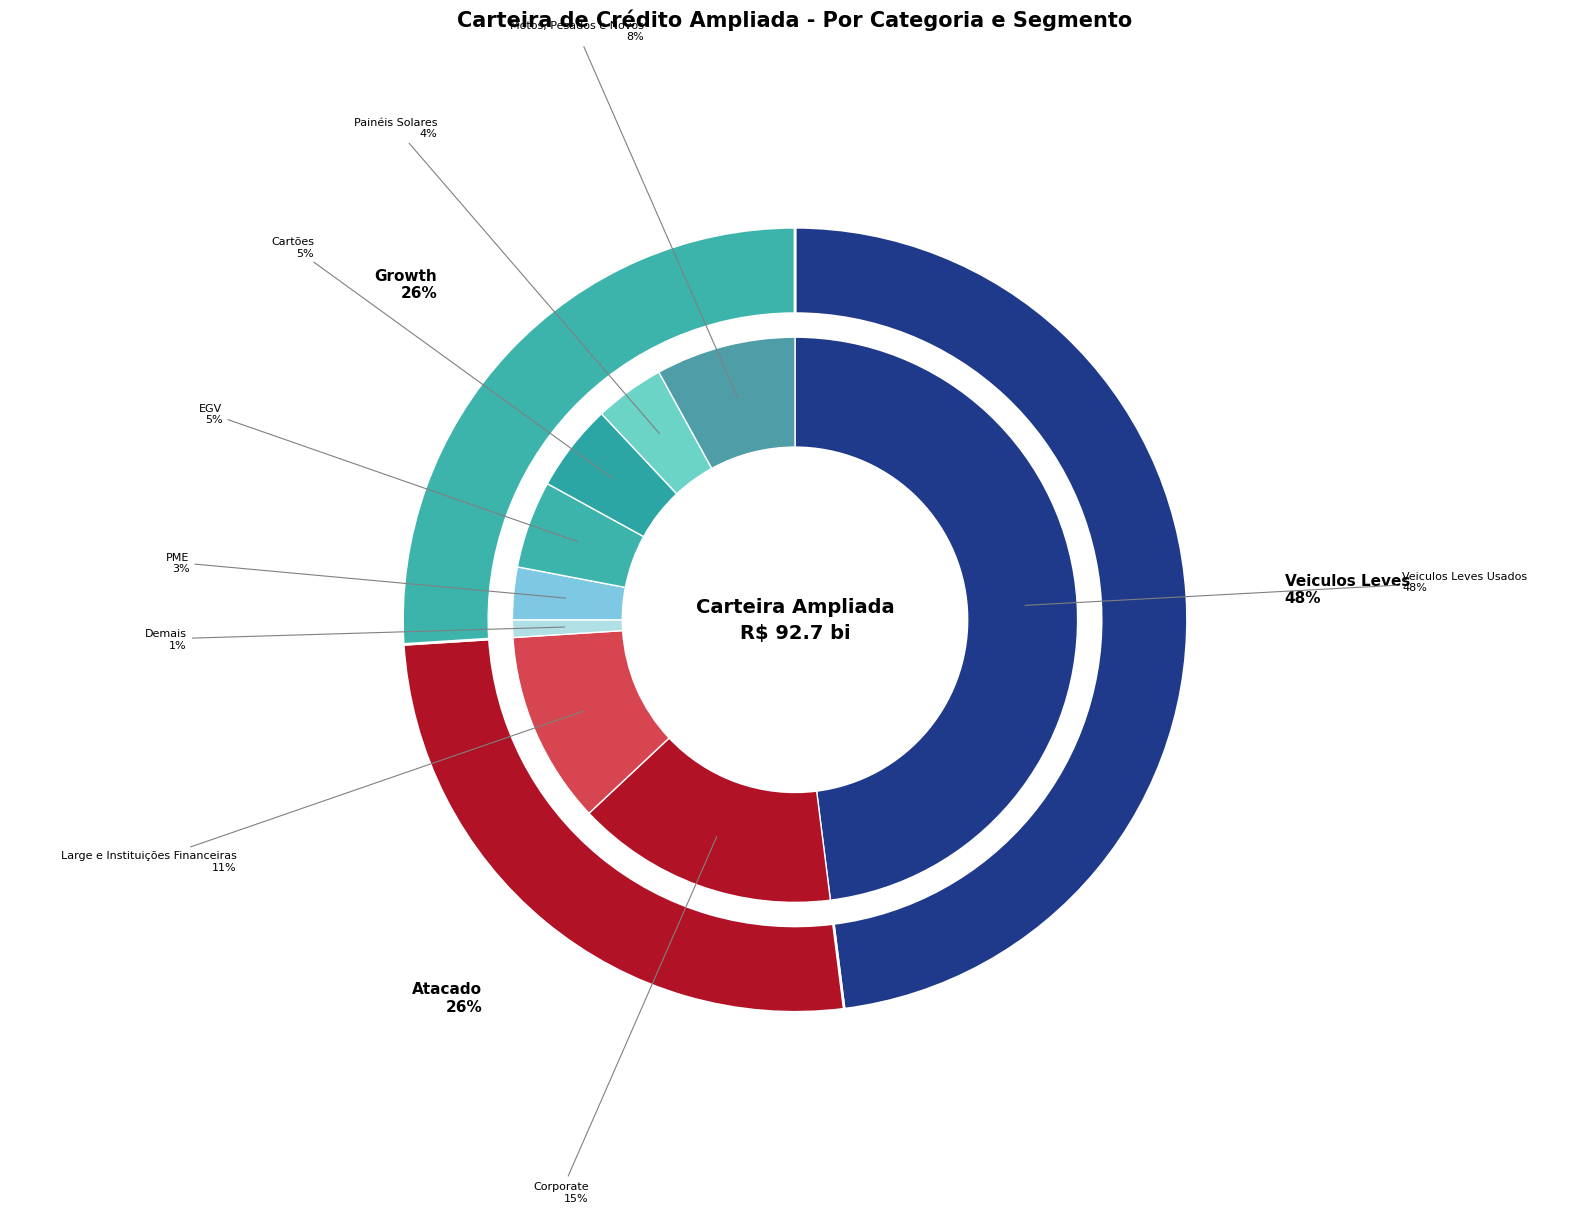

In [21]:
def plot_nested_donut_with_labels(
    inner_labels, inner_values, 
    outer_labels, outer_values,
    center_text, title=None, 
    inner_colors=None, outer_colors=None,
    figsize=(14, 10)
):
    """
    Plota um gráfico de donut com dois anéis e labels nas fatias internas.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Anel EXTERNO (categorias) - SEM labels automáticos, vamos adicionar manualmente
    outer_result = ax.pie(
        outer_values,
        startangle=90,
        counterclock=False,
        colors=outer_colors,
        wedgeprops=dict(width=0.22, edgecolor="white", linewidth=2),
        radius=1.0,
    )
    outer_wedges = outer_result[0]
    
    # Adiciona labels das categorias (anel externo)
    outer_total = sum(outer_values)
    for wedge, label, value in zip(outer_wedges, outer_labels, outer_values):
        ang = (wedge.theta2 + wedge.theta1) / 2
        pct = value / outer_total * 100
        
        # Posição do label mais afastada
        x_label = 1.25 * np.cos(np.deg2rad(ang))
        y_label = 1.25 * np.sin(np.deg2rad(ang))
        
        ha = "left" if x_label > 0 else "right"
        
        ax.text(
            x_label, y_label,
            f"{label}\n{pct:.0f}%",
            ha=ha, va="center",
            fontsize=11, fontweight="bold",
        )
    
    # Anel INTERNO (detalhes) - SEM labels automáticos
    inner_result = ax.pie(
        inner_values,
        startangle=90,
        counterclock=False,
        colors=inner_colors,
        wedgeprops=dict(width=0.28, edgecolor="white", linewidth=1),
        radius=0.72,
    )
    inner_wedges = inner_result[0]
    
    # Adiciona labels manualmente nas fatias internas com linhas de conexão
    total = sum(inner_values)
    for i, (wedge, label, value) in enumerate(zip(inner_wedges, inner_labels, inner_values)):
        # Calcula o ângulo médio da fatia
        ang = (wedge.theta2 + wedge.theta1) / 2
        
        # Ponto no meio da fatia (para a linha de conexão)
        x_wedge = 0.58 * np.cos(np.deg2rad(ang))
        y_wedge = 0.58 * np.sin(np.deg2rad(ang))
        
        # Ponto externo para o label - mais afastado
        label_dist = 1.55
        x_label = label_dist * np.cos(np.deg2rad(ang))
        y_label = label_dist * np.sin(np.deg2rad(ang))
        
        # Calcula a porcentagem
        pct = value / total * 100
        
        # Texto com label e porcentagem
        label_text = f"{label}\n{pct:.0f}%"
        
        # Alinhamento horizontal baseado na posição
        ha = "left" if x_label > 0 else "right"
        
        # Desenha a linha de conexão
        ax.annotate(
            label_text,
            xy=(x_wedge, y_wedge),
            xytext=(x_label, y_label),
            fontsize=8,
            ha=ha,
            va="center",
            arrowprops=dict(
                arrowstyle="-",
                color="gray",
                lw=0.8,
                connectionstyle="arc3,rad=0"
            ),
        )
    
    # Texto central
    ax.text(
        0, 0, center_text,
        ha="center", va="center",
        fontsize=14, fontweight="bold",
        linespacing=1.5,
    )
    
    if title:
        ax.set_title(title, fontsize=15, fontweight="bold", pad=25)
    
    ax.axis("equal")
    ax.set_xlim(-2.0, 2.0)
    ax.set_ylim(-1.8, 1.8)
    plt.tight_layout()
    return fig, ax


# Plotar com a nova função
fig, ax = plot_nested_donut_with_labels(
    inner_labels=labels,
    inner_values=values,
    outer_labels=cat_labels,
    outer_values=cat_values,
    center_text=f"Carteira Ampliada\nR$ {total_value:.1f} bi",
    title="Carteira de Crédito Ampliada - Por Categoria e Segmento",
    inner_colors=inner_colors,
    outer_colors=outer_colors,
    figsize=(16, 12),
)
plt.show()

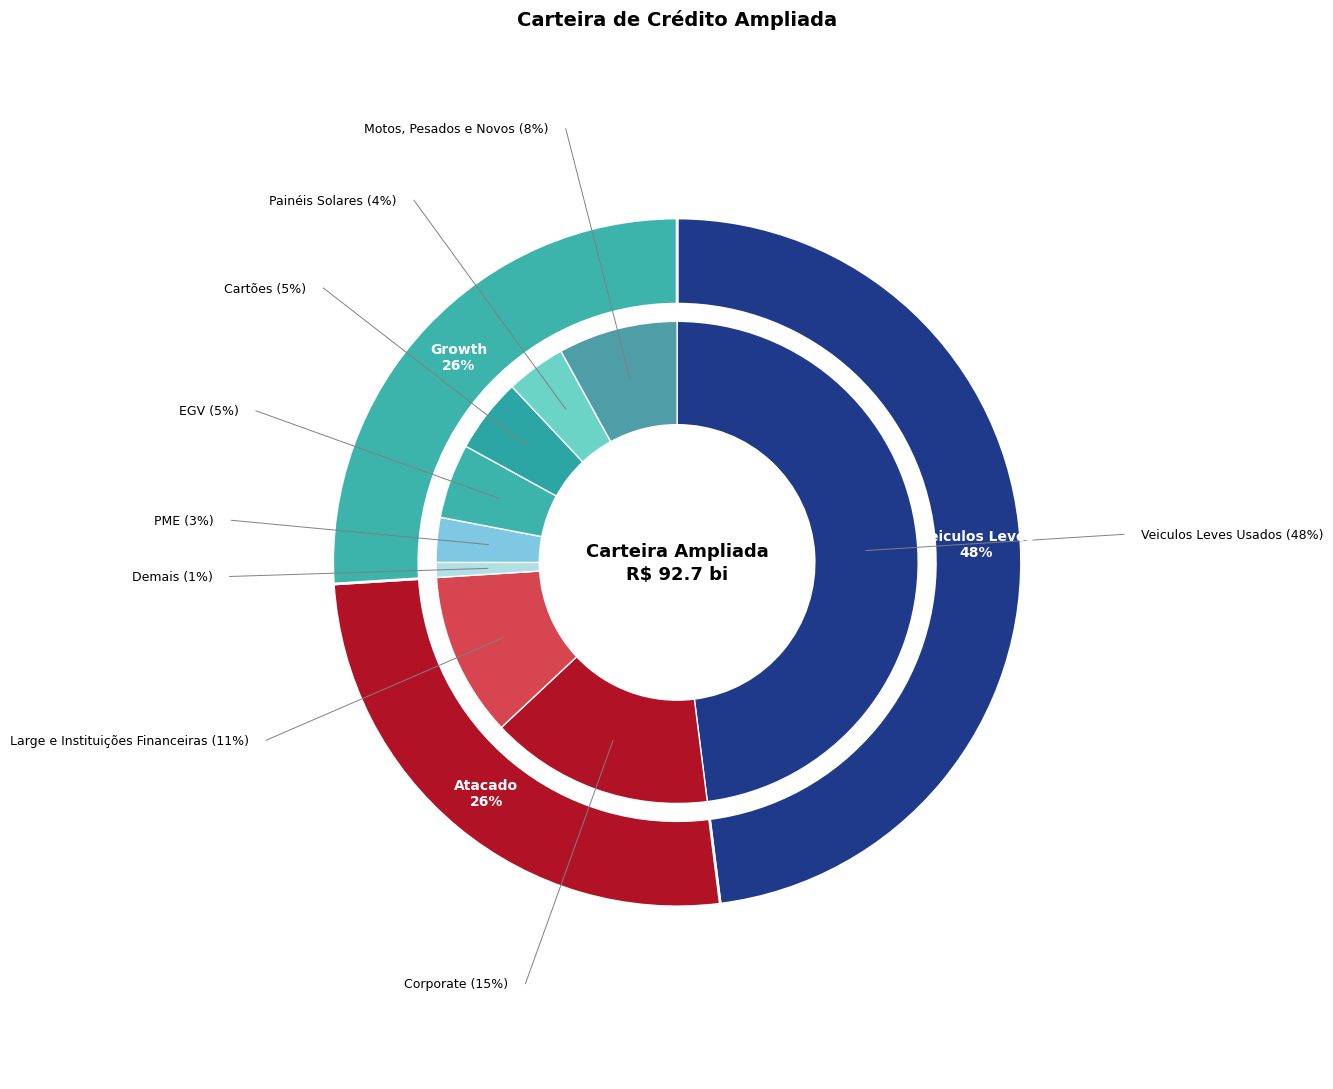

In [22]:
# Versão mais limpa: labels das categorias no anel externo, segmentos no interno
def plot_clean_nested_donut(
    inner_labels, inner_values, 
    outer_labels, outer_values,
    center_text, title=None, 
    inner_colors=None, outer_colors=None,
    figsize=(12, 10)
):
    """
    Gráfico de donut duplo com labels limpos.
    - Anel externo: Categorias (com % dentro da fatia)
    - Anel interno: Segmentos (com labels conectados por linhas)
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # --- ANEL EXTERNO (Categorias) ---
    outer_result = ax.pie(
        outer_values,
        startangle=90,
        counterclock=False,
        colors=outer_colors,
        wedgeprops=dict(width=0.25, edgecolor="white", linewidth=2),
        radius=1.0,
    )
    outer_wedges = outer_result[0]
    
    # Labels das categorias posicionados DENTRO das fatias externas
    outer_total = sum(outer_values)
    for wedge, label, value in zip(outer_wedges, outer_labels, outer_values):
        ang = (wedge.theta2 + wedge.theta1) / 2
        pct = value / outer_total * 100
        
        # Posição no meio do anel externo
        r = 0.87  # raio médio do anel externo
        x = r * np.cos(np.deg2rad(ang))
        y = r * np.sin(np.deg2rad(ang))
        
        # Rotação do texto para acompanhar o ângulo
        rotation = ang - 90 if -90 < ang < 90 or ang > 270 else ang + 90
        
        ax.text(
            x, y,
            f"{label}\n{pct:.0f}%",
            ha="center", va="center",
            fontsize=10, fontweight="bold",
            color="white",
            rotation=0,  # sem rotação para melhor leitura
        )
    
    # --- ANEL INTERNO (Segmentos) ---
    inner_result = ax.pie(
        inner_values,
        startangle=90,
        counterclock=False,
        colors=inner_colors,
        wedgeprops=dict(width=0.30, edgecolor="white", linewidth=1),
        radius=0.70,
    )
    inner_wedges = inner_result[0]
    
    # Labels dos segmentos com linhas de conexão
    inner_total = sum(inner_values)
    
    # Calcula posições dos labels evitando sobreposição
    label_positions = []
    for i, (wedge, label, value) in enumerate(zip(inner_wedges, inner_labels, inner_values)):
        ang = (wedge.theta2 + wedge.theta1) / 2
        pct = value / inner_total * 100
        
        # Ponto de origem na fatia
        x_start = 0.55 * np.cos(np.deg2rad(ang))
        y_start = 0.55 * np.sin(np.deg2rad(ang))
        
        # Ponto final do label (fora do gráfico)
        label_dist = 1.3
        x_end = label_dist * np.cos(np.deg2rad(ang))
        y_end = label_dist * np.sin(np.deg2rad(ang))
        
        label_positions.append({
            'label': label,
            'pct': pct,
            'ang': ang,
            'x_start': x_start,
            'y_start': y_start,
            'x_end': x_end,
            'y_end': y_end,
        })
    
    # Desenha os labels com linhas
    for pos in label_positions:
        ha = "left" if pos['x_end'] > 0 else "right"
        
        # Linha de conexão
        ax.plot(
            [pos['x_start'], pos['x_end']], 
            [pos['y_start'], pos['y_end']],
            color='gray', lw=0.7, ls='-'
        )
        
        # Label
        ax.text(
            pos['x_end'] + (0.05 if ha == "left" else -0.05),
            pos['y_end'],
            f"{pos['label']} ({pos['pct']:.0f}%)",
            ha=ha, va="center",
            fontsize=9,
        )
    
    # --- TEXTO CENTRAL ---
    ax.text(
        0, 0, center_text,
        ha="center", va="center",
        fontsize=13, fontweight="bold",
        linespacing=1.4,
    )
    
    if title:
        ax.set_title(title, fontsize=14, fontweight="bold", pad=15)
    
    ax.set_aspect('equal')
    ax.set_xlim(-1.7, 1.7)
    ax.set_ylim(-1.5, 1.5)
    plt.tight_layout()
    return fig, ax


# Plotar
fig, ax = plot_clean_nested_donut(
    inner_labels=labels,
    inner_values=values,
    outer_labels=cat_labels,
    outer_values=cat_values,
    center_text=f"Carteira Ampliada\nR$ {total_value:.1f} bi",
    title="Carteira de Crédito Ampliada",
    inner_colors=inner_colors,
    outer_colors=outer_colors,
    figsize=(14, 11),
)
plt.show()

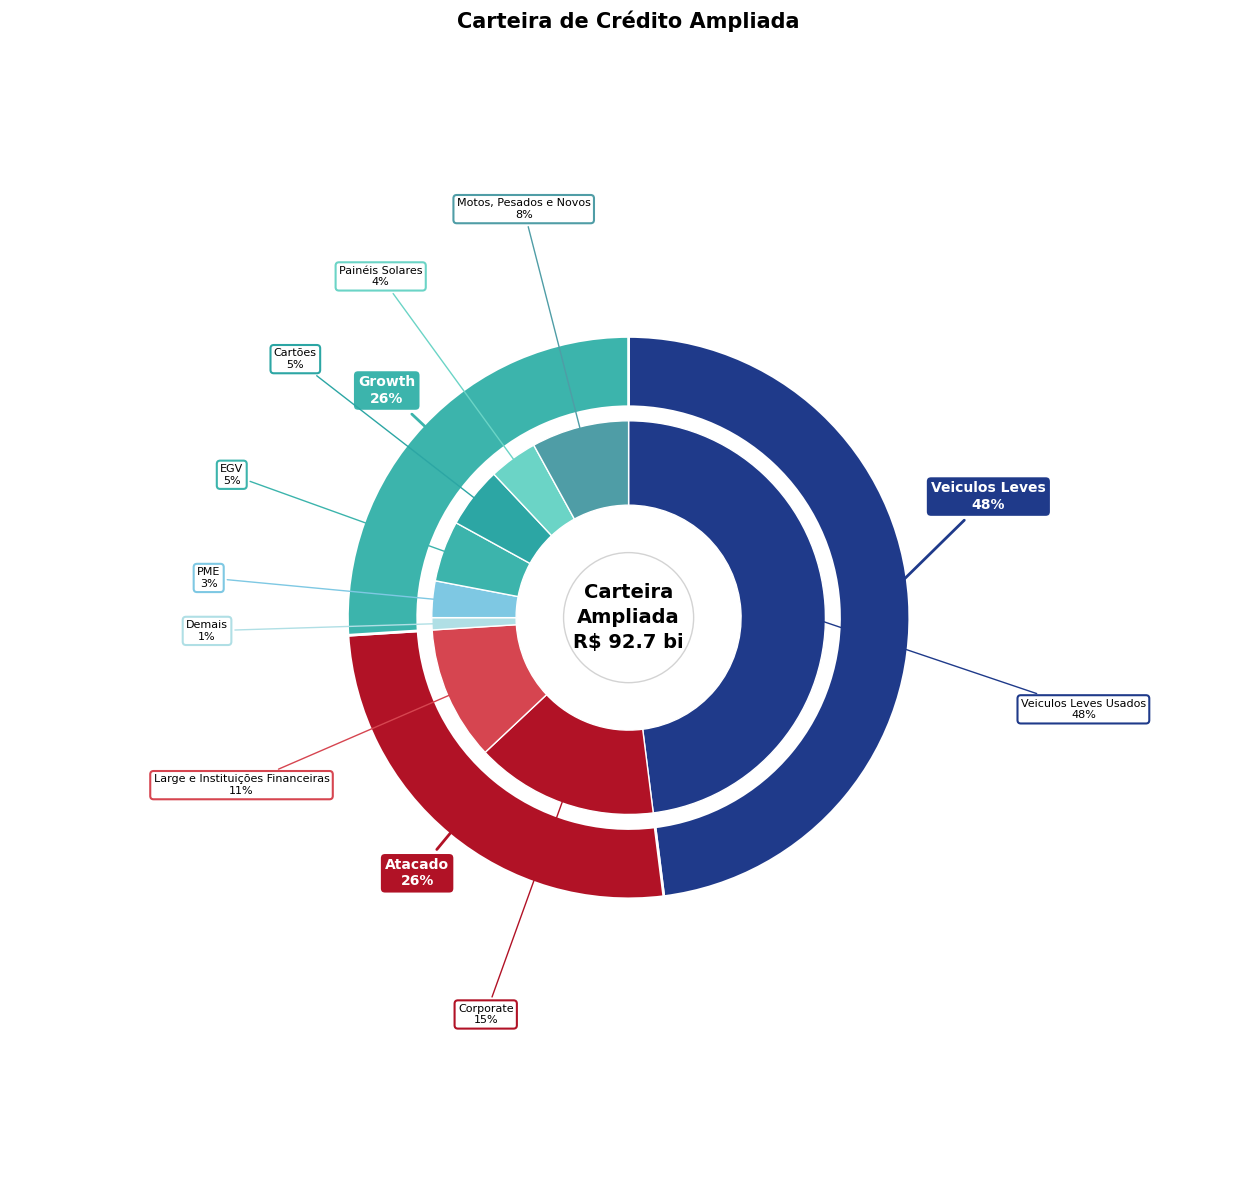

In [24]:
# Versão com labels em caixas/quadrados sobre as fatias
def plot_donut_with_boxes(
    inner_labels, inner_values, 
    outer_labels, outer_values,
    center_text, title=None, 
    inner_colors=None, outer_colors=None,
    figsize=(14, 11)
):
    """
    Gráfico de donut duplo com labels em caixas retangulares.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # --- ANEL EXTERNO (Categorias) ---
    outer_result = ax.pie(
        outer_values,
        startangle=90,
        counterclock=False,
        colors=outer_colors,
        wedgeprops=dict(width=0.25, edgecolor="white", linewidth=2),
        radius=1.0,
    )
    outer_wedges = outer_result[0]
    
    # --- ANEL INTERNO (Segmentos) ---
    inner_result = ax.pie(
        inner_values,
        startangle=90,
        counterclock=False,
        colors=inner_colors,
        wedgeprops=dict(width=0.30, edgecolor="white", linewidth=1),
        radius=0.70,
    )
    inner_wedges = inner_result[0]
    
    # --- LABELS DAS CATEGORIAS (anel externo) em caixas ---
    outer_total = sum(outer_values)
    for i, (wedge, label, value, color) in enumerate(zip(outer_wedges, outer_labels, outer_values, outer_colors)):
        ang = (wedge.theta2 + wedge.theta1) / 2
        pct = value / outer_total * 100
        
        # Ajuste especial para "Veiculos Leves" - move mais para cima/direita
        if "Veiculos" in label or "Veículos" in label:
            r = 1.35  # Mais afastado
            ang_offset = 15  # Desloca o ângulo
            ang_adjusted = ang + ang_offset
        else:
            r = 1.18
            ang_adjusted = ang
        
        x = r * np.cos(np.deg2rad(ang_adjusted))
        y = r * np.sin(np.deg2rad(ang_adjusted))
        
        # Caixa com a cor da fatia
        ax.annotate(
            f"{label}\n{pct:.0f}%",
            xy=(0.9 * np.cos(np.deg2rad(ang)), 0.9 * np.sin(np.deg2rad(ang))),
            xytext=(x, y),
            fontsize=10,
            fontweight="bold",
            ha="center",
            va="center",
            color="white",
            bbox=dict(
                boxstyle="round,pad=0.4",
                facecolor=color,
                edgecolor="white",
                linewidth=2,
            ),
            arrowprops=dict(
                arrowstyle="-",
                color=color,
                lw=2,
            ),
        )
    
    # --- LABELS DOS SEGMENTOS (anel interno) em caixas ---
    inner_total = sum(inner_values)
    for i, (wedge, label, value, color) in enumerate(zip(inner_wedges, inner_labels, inner_values, inner_colors)):
        ang = (wedge.theta2 + wedge.theta1) / 2
        pct = value / inner_total * 100
        
        # Posição: ponto de origem na fatia
        r_start = 0.55
        x_start = r_start * np.cos(np.deg2rad(ang))
        y_start = r_start * np.sin(np.deg2rad(ang))
        
        # Ajuste especial para "Veiculos Leves Usados" - move mais para baixo/direita
        if "Usados" in label:
            r_end = 1.65
            ang_offset = -15  # Desloca para baixo
            ang_adjusted = ang + ang_offset
        else:
            r_end = 1.50
            ang_adjusted = ang
        
        x_end = r_end * np.cos(np.deg2rad(ang_adjusted))
        y_end = r_end * np.sin(np.deg2rad(ang_adjusted))
        
        # Caixa com fundo branco e borda da cor da fatia
        ax.annotate(
            f"{label}\n{pct:.0f}%",
            xy=(x_start, y_start),
            xytext=(x_end, y_end),
            fontsize=8,
            ha="center",
            va="center",
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor="white",
                edgecolor=color,
                linewidth=1.5,
            ),
            arrowprops=dict(
                arrowstyle="-",
                color=color,
                lw=1,
            ),
        )
    
    # --- TEXTO CENTRAL ---
    ax.text(
        0, 0, center_text,
        ha="center", va="center",
        fontsize=14, fontweight="bold",
        linespacing=1.4,
        bbox=dict(
            boxstyle="circle,pad=0.5",
            facecolor="white",
            edgecolor="lightgray",
            linewidth=1,
        ),
    )
    
    if title:
        ax.set_title(title, fontsize=15, fontweight="bold", pad=20)
    
    ax.set_aspect('equal')
    ax.set_xlim(-2.2, 2.2)
    ax.set_ylim(-2.0, 2.0)
    plt.tight_layout()
    return fig, ax


# Plotar
fig, ax = plot_donut_with_boxes(
    inner_labels=labels,
    inner_values=values,
    outer_labels=cat_labels,
    outer_values=cat_values,
    center_text=f"Carteira\nAmpliada\nR$ {total_value:.1f} bi",
    title="Carteira de Crédito Ampliada",
    inner_colors=inner_colors,
    outer_colors=outer_colors,
    figsize=(16, 12),
)
plt.show()

## Teste do módulo utils - Gráfico de Pizza
Testando a função `plot_donut_from_excel` e `generate_pizza_charts` do módulo utils.

In [25]:
# Teste usando o módulo utils
from pathlib import Path
from utils.charts_common import ExcelDonutChartSpec, plot_donut_from_excel, close_figure
from utils.slide_pizza_charts import generate_pizza_charts

# Gerar usando a função do módulo
output_dir = Path("output/pizza")
output_dir.mkdir(parents=True, exist_ok=True)

# Teste direto com ExcelDonutChartSpec
fig, ax = plot_donut_from_excel(
    ExcelDonutChartSpec(
        file_path=EXCEL_FILE,
        sheet_name="Pizza Teste",
        categories_range="A2:A10",
        labels_range="B2:B10",
        values_range="C2:C10",
        center_text="Carteira\nAmpliada\nR$ 92.7 bi",
        title="Carteira de Crédito Ampliada (via utils)",
        output_path=output_dir / "pizza_test_utils.png",
    )
)
print(f"✅ Gráfico salvo em: {output_dir / 'pizza_test_utils.png'}")
plt.show()
close_figure(fig)

✅ Gráfico salvo em: output/pizza/pizza_test_utils.png


/tmp/ipykernel_44597/3416082406.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [26]:
# Teste usando generate_pizza_charts (função completa do slide)
from utils.slide_pizza_charts import generate_pizza_charts

generated_files = generate_pizza_charts(
    xlsx_path=Path(EXCEL_FILE),
    output_dir=Path("output/pizza_slide"),
)

print("Arquivos gerados:")
for f in generated_files:
    print(f"  ✅ {f}")

Arquivos gerados:
  ✅ output/pizza_slide/pizza_carteira_credito.png


In [27]:
# Explorar os dados nas coordenadas H3:J4 e K3:L4 da worksheet "Pizza Teste"
print("Dados em H3:J3 (labels) e H4:J4 (valores):")
for col in range(8, 11):  # H=8, I=9, J=10
    label = ws_pizza.cell(row=3, column=col).value
    value = ws_pizza.cell(row=4, column=col).value
    print(f"  Col {chr(64+col)}: {label} = {value}")

print("\nDados em K3:L3 (labels) e K4:L4 (valores):")
for col in range(11, 13):  # K=11, L=12
    label = ws_pizza.cell(row=3, column=col).value
    value = ws_pizza.cell(row=4, column=col).value
    print(f"  Col {chr(64+col)}: {label} = {value}")

Dados em H3:J3 (labels) e H4:J4 (valores):
  Col H: 3T24 = 685
  Col I: 2T25 = 556
  Col J: 3T25 = 624

Dados em K3:L3 (labels) e K4:L4 (valores):
  Col K: 9M24 = 1984
  Col L: 9M25 = 1798


In [28]:
# Gráficos de barras estilo 02_lucro_9m para as coordenadas especificadas
from utils.charts_common import ExcelBarChartSpec, plot_bar_from_excel, close_figure

output_dir = Path("output/pizza_bars")
output_dir.mkdir(parents=True, exist_ok=True)

# Gráfico 1: H3:J3 (labels) / H4:J4 (valores) - Trimestres (3 barras)
fig1, ax1 = plot_bar_from_excel(
    ExcelBarChartSpec(
        file_path=EXCEL_FILE,
        sheet_name="Pizza Teste",
        values_range="H4:J4",
        xlabels_range="H3:J3",
        title=None,
        highlight_last=True,
        show_delta_pct=True,
        show_delta_bracket=True,
        delta_pairs=((-2, -1),),  # Compara penúltimo com último
        output_path=output_dir / "pizza_bar_trimestres.png",
    )
)
print(f"✅ Gráfico 1 salvo: {output_dir / 'pizza_bar_trimestres.png'}")
close_figure(fig1)

# Gráfico 2: K3:L3 (labels) / K4:L4 (valores) - 9M (2 barras com fixed_slot_count)
fig2, ax2 = plot_bar_from_excel(
    ExcelBarChartSpec(
        file_path=EXCEL_FILE,
        sheet_name="Pizza Teste",
        values_range="K4:L4",
        xlabels_range="K3:L3",
        title=None,
        highlight_last=True,
        show_delta_pct=True,
        show_delta_bracket=True,
        fixed_slot_count=9,  # Similar ao 02_lucro_9m
        output_path=output_dir / "pizza_bar_9m.png",
    )
)
print(f"✅ Gráfico 2 salvo: {output_dir / 'pizza_bar_9m.png'}")

✅ Gráfico 1 salvo: output/pizza_bars/pizza_bar_trimestres.png
✅ Gráfico 2 salvo: output/pizza_bars/pizza_bar_9m.png
